# Random Forest Regression Juypter Notebook File

### Use for predicting protein abundance continous values

1. **Mount Google Drive** (if using Colab Notebooks), or download entire repository with data files

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Import statements

In [ ]:
!pip install biopython # otherwise the data_prep_functions will not be imported!
!pip install scikit-learn==1.5.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 81.9 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.0
    Uninstalling scikit-learn-1.6.0:
      Successfully uninstalled scikit-learn-1.6.0


In [ ]:
from google.colab import drive
import os
import sys

drive.mount('/content/drive', force_remount=True)
data_prep_path = '/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/'
sys.path.append(data_prep_path)

from data_prep_functions import *

import threading
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pprint
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from scipy.stats import  spearmanr
from sklearn.model_selection import KFold, train_test_split, GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.feature_selection import RFE, RFECV, f_regression
from sklearn.model_selection import StratifiedKFold

Mounted at /content/drive
test! updated 'scorer' function


## Link to proteomic data file

### select file processed through Data_Consolidation.ipynb file

In [ ]:
excel_files = ['/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Input_DataFrames/df_Bov Swiss Intensity _original.xlsx']

Find smallest value in 'Abundance_Controls' column, use to replace any instance of zero in column. Save to 'post_clean_up_dfs' folder.

In [ ]:
# Iterate over each Excel file
for file in excel_files:
    # Read the Excel file into a DataFrame
    df = pd.read_excel(file, header=0)

    # Get the minimum control value
    Min_Control = df['Abundance_Controls'].drop_duplicates().nsmallest(2).iloc[-1]
    # Replace 0 values in 'Abundance_Controls' column with the second-smallest value
    df['Abundance_Controls'].replace(0, Min_Control, inplace=True)

    # Filter out rows with abundance values below zero
    Min_Abundance = df['Abundance'].drop_duplicates().nsmallest(2).iloc[-1]
    df = df[df['Abundance'] >= Min_Abundance]

    # Extract the filename without extension
    file_name = os.path.splitext(os.path.basename(file))[0]

    # Specify the output file path with the current filename included
    output_file_path = os.path.join('/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Input_DataFrames/post_clean_up_dfs/RFR/', f'{file_name}.xlsx')
    df.to_excel(output_file_path, index=False)
    print(file_name)

<ipython-input-5-ebd4415ff1f5>:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Abundance_Controls'].replace(0, Min_Control, inplace=True)


df_Bov Swiss Intensity _original


Split the cleaned data (from above code cell) into training and testing data splits and save.

In [ ]:
# Load the CLEANED (above code cell) data from an Excel file into a pandas DataFrame
file_name = 'Bov SP Intensity'
data_file_path = '/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Input_DataFrames/post_clean_up_dfs/RFR/df_Bov Swiss Intensity _original.xlsx'
data = pd.read_excel(data_file_path)

# Split the data into 90% for training and 10% for testing
train_data, test_data = train_test_split(data, test_size=0.10, random_state=42)

# Specify the file paths where you want to save the Excel files
train_file_path = (f'/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Input_DataFrames/post_clean_up_dfs/RFR/train_data_{file_name}_original.xlsx')
test_file_path = (f'/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Input_DataFrames/post_clean_up_dfs/RFR/test_data_{file_name}_original.xlsx')

# Save the training data to the specified Excel file
train_data.to_excel(train_file_path, index=False)

# Save the test data to the specified Excel file
test_data.to_excel(test_file_path, index=False)

print(f"Train dataset saved to {train_file_path}")
print(f"Test dataset saved to {test_file_path}")


Train dataset saved to /content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Input_DataFrames/post_clean_up_dfs/RFR/train_data_Bov SP Intensity_original.xlsx
Test dataset saved to /content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Input_DataFrames/post_clean_up_dfs/RFR/test_data_Bov SP Intensity_original.xlsx


ANOVA analysis and selected feature plotting functions.

In [ ]:
def calculate_anova(X, y):
    f_values, p_values = f_regression(X, y)
    return f_values, p_values

def rank_features_by_anova(X, y, feature_names):
    full_name_dict = {
        'Abundance_Controls' : 'Control Abundance',
          'frac_aa_A': '% Amino Acid - Alanine (A)',
          'frac_aa_C': '% Amino Acid - Cysteine (C)',
          'frac_aa_D': '% Amino Acid - Aspartic Acid (D)',
          'frac_aa_E': '% Amino Acid - Glutamic Acid (E)',
          'frac_aa_F': '% Amino Acid - Phenylalanine (F)',
          'frac_aa_G': '% Amino Acid - Glycine (G)',
          'frac_aa_H': '% Amino Acid - Histidine (H)',
          'frac_aa_I': '% Amino Acid - Isoleucine (I)',
          'frac_aa_K': '% Amino Acid - Lysine (K)',
          'frac_aa_L': '% Amino Acid - Leucine (L)',
          'frac_aa_M': '% Amino Acid - Methionine (M)',
          'frac_aa_N': '% Amino Acid - Asparagine (N)',
          'frac_aa_P': '% Amino Acid - Proline (P)',
          'frac_aa_Q': '% Amino Acid - Glutamine (Q)',
          'frac_aa_R': '% Amino Acid - Arginine (R)',
          'frac_aa_S': '% Amino Acid - Serine (S)',
          'frac_aa_T': '% Amino Acid - Threonine (T)',
          'frac_aa_V': '% Amino Acid - Valine (V)',
          'frac_aa_W': '% Amino Acid - Tryptophan (W)',
          'frac_aa_Y': '% Amino Acid - Tyrosine (Y)',
          'gravy': 'GRAVY score',
          'aromaticity': 'Aromaticity',
          'instability_index': 'Instability Index',
          'flexibility_mean': 'Flexibility - Mean',
          'flexibility_std': 'Flexibility - Standard Deviation',
          'flexibility_var': 'Flexibility - Variance',
          'flexibility_max': 'Flexibility - Max',
          'flexibility_min': 'Flexibility - Min',
          'flexibility_median': 'Flexibility - Median',
          'isoelectric_point': 'Isoelectric Point',
          'secondary_structure_fraction_helix': '% Secondary Structure-Associated Amino Acids – Helix',
          'secondary_structure_fraction_turn': '% Secondary Structure-Associated Amino Acids – Turn',
          'secondary_structure_fraction_sheet': '% Secondary Structure-Associated Amino Acids – Sheet',
          'secondary_structure_fraction_disordered': '% Secondary Structure-Associated Amino Acids - Non-Structure Associated',
          'length': 'Length',
          'molecular_weight': 'Molecular Weight',
          'fraction_exposed': '% Amino Acids Exposed',
          'fraction_buried': '% Amino Acids Buried',
          'fraction_exposed_nonpolar_total': '% Exposed Nonpolar Amino Acids / Total Amino Acids',
          'fraction_exposed_nonpolar_exposed': '% Exposed Nonpolar Amino Acids / Total Exposed',
          'fraction_exposed_polar_total': '% Exposed Polar Amino Acids / Total Amino Acids',
          'fraction_exposed_polar_exposed': '% Exposed Polar Amino Acids / Total Exposed',
          'rsa_mean': 'Relative Surface Area (RSA) - Mean',
          'rsa_median': 'Relative Surface Area - Median',
          'rsa_std': 'Relative Surface Area - Standard Deviation',
          'asa_sum': 'Absolute Surface Area (ASA) - Sum',
          'fraction_total_exposed_A': '% Exposed Amino Acid A / Total Amino Acids',
          'fraction_total_exposed_C': '% Exposed Amino Acid C / Total Amino Acids',
          'fraction_total_exposed_D': '% Exposed Amino Acid D / Total Amino Acids',
          'fraction_total_exposed_E': '% Exposed Amino Acid E / Total Amino Acids',
          'fraction_total_exposed_F': '% Exposed Amino Acid F / Total Amino Acids',
          'fraction_total_exposed_G': '% Exposed Amino Acid G / Total Amino Acids',
          'fraction_total_exposed_H': '% Exposed Amino Acid H / Total Amino Acids',
          'fraction_total_exposed_I': '% Exposed Amino Acid I / Total Amino Acids',
          'fraction_total_exposed_K': '% Exposed Amino Acid K / Total Amino Acids',
          'fraction_total_exposed_L': '% Exposed Amino Acid L / Total Amino Acids',
          'fraction_total_exposed_M': '% Exposed Amino Acid M / Total Amino Acids',
          'fraction_total_exposed_N': '% Exposed Amino Acid N / Total Amino Acids',
          'fraction_total_exposed_P': '% Exposed Amino Acid P / Total Amino Acids',
          'fraction_total_exposed_Q': '% Exposed Amino Acid Q / Total Amino Acids',
          'fraction_total_exposed_R': '% Exposed Amino Acid R / Total Amino Acids',
          'fraction_total_exposed_S': '% Exposed Amino Acid S / Total Amino Acids',
          'fraction_total_exposed_T': '% Exposed Amino Acid T / Total Amino Acids',
          'fraction_total_exposed_V': '% Exposed Amino Acid V / Total Amino Acids',
          'fraction_total_exposed_W': '% Exposed Amino Acid W / Total Amino Acids',
          'fraction_total_exposed_Y': '% Exposed Amino Acid Y / Total Amino Acids',
          'fraction_exposed_exposed_A': '% Exposed Amino Acid A / Total Exposed',
          'fraction_exposed_exposed_C': '% Exposed Amino Acid C / Total Exposed',
          'fraction_exposed_exposed_D': '% Exposed Amino Acid D / Total Exposed',
          'fraction_exposed_exposed_E': '% Exposed Amino Acid E / Total Exposed',
          'fraction_exposed_exposed_F': '% Exposed Amino Acid F / Total Exposed',
          'fraction_exposed_exposed_G': '% Exposed Amino Acid G / Total Exposed',
          'fraction_exposed_exposed_H': '% Exposed Amino Acid H / Total Exposed',
          'fraction_exposed_exposed_I': '% Exposed Amino Acid I / Total Exposed',
          'fraction_exposed_exposed_K': '% Exposed Amino Acid K / Total Exposed',
          'fraction_exposed_exposed_L': '% Exposed Amino Acid L / Total Exposed',
          'fraction_exposed_exposed_M': '% Exposed Amino Acid M / Total Exposed',
          'fraction_exposed_exposed_N': '% Exposed Amino Acid N / Total Exposed',
          'fraction_exposed_exposed_P': '% Exposed Amino Acid P / Total Exposed',
          'fraction_exposed_exposed_Q': '% Exposed Amino Acid Q / Total Exposed',
          'fraction_exposed_exposed_R': '% Exposed Amino Acid R / Total Exposed',
          'fraction_exposed_exposed_S': '% Exposed Amino Acid S / Total Exposed',
          'fraction_exposed_exposed_T': '% Exposed Amino Acid T / Total Exposed',
          'fraction_exposed_exposed_V': '% Exposed Amino Acid V / Total Exposed',
          'fraction_exposed_exposed_W': '% Exposed Amino Acid W / Total Exposed',
          'fraction_exposed_exposed_Y': '% Exposed Amino Acid Y / Total Exposed',
          'asa_sum_normalized': 'Sum of Absolute Surface Area / Total Mass',
          'nsp_secondary_structure_helix': '% Secondary Structure - Helix',
          'nsp_secondary_structure_sheet': '% Secondary Structure - Sheet',
          'nsp_secondary_structure_coiled': '% Secondary Structure - Coil',
          'nsp_disordered': '% Secondary Structure - Disordered'
    }

    f_values, p_values = calculate_anova(X, y)
    full_feature_names = [full_name_dict.get(name, name) for name in feature_names]

    feature_importances = pd.DataFrame({
        'Feature': full_feature_names,
        'F-Value': f_values,
        'P-Value': p_values
    })

    ranked_features = feature_importances.sort_values(by='F-Value', ascending=False)
    return ranked_features

def plot_top_features(ranked_features, name):
    top_features = ranked_features.head(10)
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.barh(top_features['Feature'], top_features['F-Value'], color='black')
    ax.set_xlabel('F-Value', fontweight='bold', color='black')
    ax.set_title(f'Top 10 Features Ranked by ANOVA for Bovine Swiss-Prot Intensity', fontweight='bold', color='black')
    plt.gca().invert_yaxis()
    plt.show()

## RFECV for RFR model
### Run to determine selected features for regression model

start Bov SP Intensity training_data
n_features_to_select 79
n_features_to_select 78
n_features_to_select 77
n_features_to_select 76
n_features_to_select 75
n_features_to_select 74
n_features_to_select 73
n_features_to_select 72
n_features_to_select 71
n_features_to_select 70
n_features_to_select 69
n_features_to_select 68
n_features_to_select 67
n_features_to_select 66
n_features_to_select 65
n_features_to_select 64
n_features_to_select 63
n_features_to_select 62
n_features_to_select 61
n_features_to_select 60
n_features_to_select 59
n_features_to_select 58
n_features_to_select 57
n_features_to_select 56
n_features_to_select 55
n_features_to_select 54
n_features_to_select 53
n_features_to_select 52
n_features_to_select 51
n_features_to_select 50
n_features_to_select 49
n_features_to_select 48
n_features_to_select 47
n_features_to_select 46
n_features_to_select 45
n_features_to_select 44
n_features_to_select 43
n_features_to_select 42
n_features_to_select 41
n_features_to_select 40
n_f

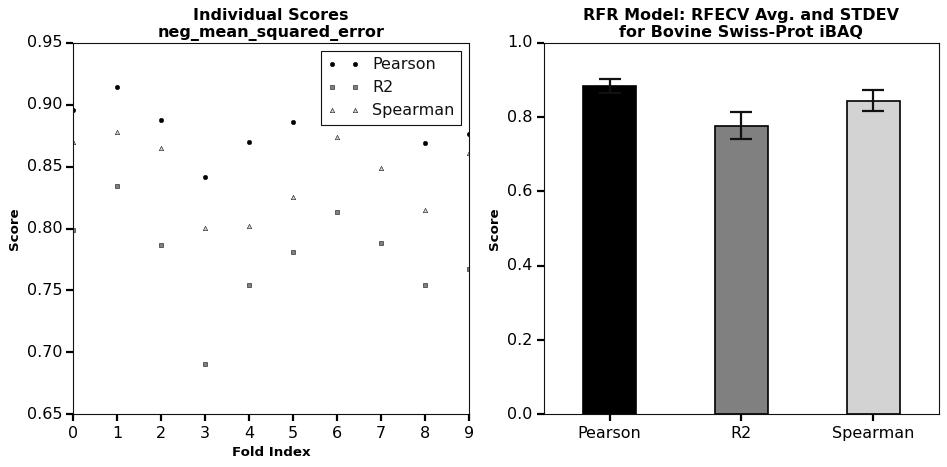

Scorer ran successfully
                                Feature  Importance
0                    Abundance_Controls   48.455916
1                             frac_aa_D    2.263209
2                             frac_aa_F    3.211496
3                             frac_aa_K    2.437954
4                             frac_aa_N    3.871528
5                                 gravy    2.051911
6          fraction_exposed_polar_total    2.912771
7                               rsa_std    2.457864
8                               asa_sum    2.821019
9            fraction_exposed_exposed_C    2.902030
10           fraction_exposed_exposed_E    2.796122
11           fraction_exposed_exposed_F    2.763978
12        nsp_secondary_structure_sheet    3.420087
13        nsp_secondary_structure_helix    2.745602
14                       Zeta Potential    7.046581
15                    Dh_functionalized    5.406792
16  NP_incubation Concentration (mg/mL)    2.435139


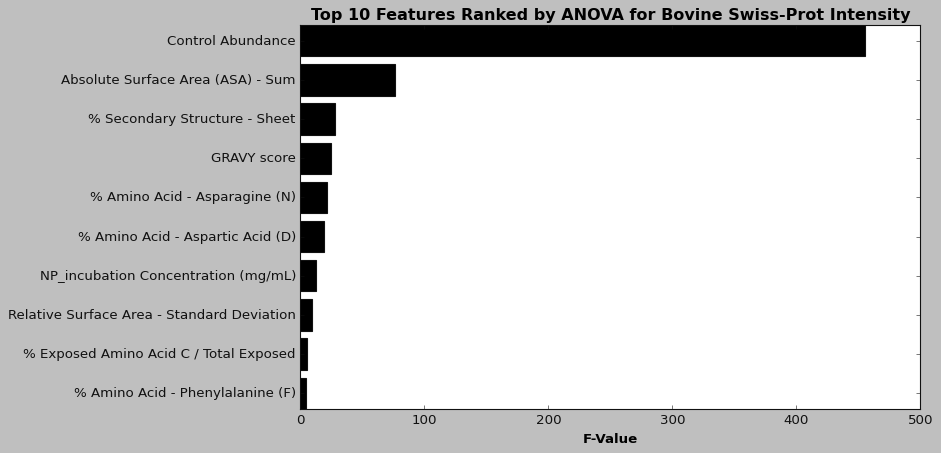

                                       Feature     F-Value       P-Value
0                            Control Abundance  455.218140  4.348549e-94
8            Absolute Surface Area (ASA) - Sum   76.387268  3.828068e-18
12               % Secondary Structure - Sheet   27.864573  1.394888e-07
5                                  GRAVY score   24.613102  7.402187e-07
4                % Amino Acid - Asparagine (N)   21.620479  3.467987e-06
1             % Amino Acid - Aspartic Acid (D)   18.980378  1.365478e-05
16         NP_incubation Concentration (mg/mL)   12.315872  4.558018e-04
7   Relative Surface Area - Standard Deviation    9.370572  2.224708e-03
9       % Exposed Amino Acid C / Total Exposed    5.056907  2.460104e-02
2             % Amino Acid - Phenylalanine (F)    4.242954  3.950054e-02


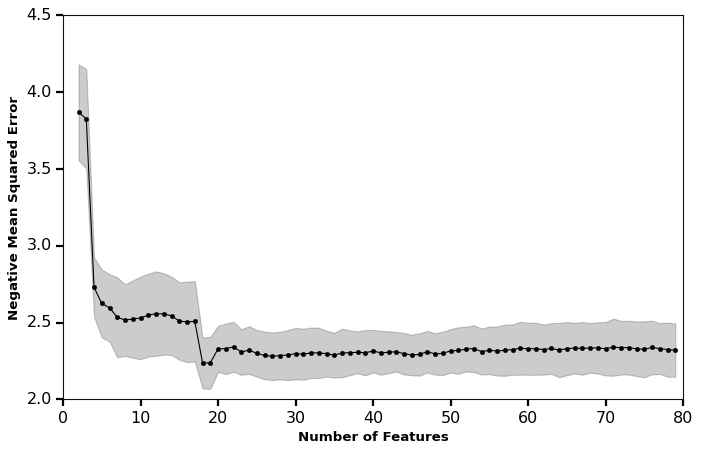

Bov SP Intensity training_data done


In [ ]:
def process_file(train_df, name):
    # Initialize a RandomForestRegressor model with 100 estimators
    model = RandomForestRegressor(n_estimators=100, random_state = 42)

    # Save a copy of the original DataFrame for later use
    train_df_original = train_df.copy()

    # 'Abundance' column in train_df represents a 1D array of target values (class labels)
    y_label = np.log2(train_df['Abundance'].to_numpy().astype(float))

    # Remove columns in train_df that should not be considered as potential features in RFE & RFECV
    columns_to_drop = [col for col in ['Abundance', 'NPUNID', 'NPID', 'Entry', 'Sequence', 'Sample_num', 'Raw_FileID',
                                       'Ligands', 'BatchID', 'Protein Source'] if col in train_df.columns]
    train_df.drop(columns=columns_to_drop, inplace=True)

    # RFECV Variables
    identifier = 'neg_mean_squared_error'
    keep_columns = ['Abundance', 'NPUNID', 'Entry']
    n_splits = 10  # go back to 10 later
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    # Define the range of features to select
    max_features = train_df.shape[1]  # equal to the number of columns in train_df
    min_features = 1

    selected_features = None
    current_score = float(100)

    df_full_results = pd.DataFrame({"Number of features": [],
                                    "Avg neg_mean_squared_err": [],
                                    "Std dev": [],
                                    "List of features": [],
                                    "Combined Score": []})
    print('start', name)

    for n_features_to_select in range(max_features, min_features, -1):
        print('n_features_to_select', n_features_to_select)
        avg_accuracies = []

        # Make a dictionary with feature name keys
        feat_dict = {key: 0 for key in train_df.columns}

        for train_index, test_index in kf.split(train_df):
            # Assert statement to ensure no train/test split overlap
            assert len(set(train_index) & set(test_index)) == 0, "Overlap found between training and testing sets"

            X_train, X_test = train_df.iloc[train_index], train_df.iloc[test_index]
            y_train, y_test = y_label[train_index], y_label[test_index]

            # Train the classifier
            model.fit(X_train, y_train)

            # Evaluate on validation set
            y_pred = model.predict(X_test)
            accuracy = mean_squared_error(y_pred, y_test)
            avg_accuracies.append(accuracy)

            # At each iteration, each feature will get an importance
            for idx, feature in enumerate(train_df.columns):
                feat_dict[feature] += model.feature_importances_[idx]

        # Compute average accuracy across all folds
        avg_accuracy = np.mean(avg_accuracies)
        std_dev = np.std(avg_accuracies)

        # If this is the best combo, save it
        combined_score = avg_accuracy + std_dev + (n_features_to_select / 5000)
        df_full_results.loc[len(df_full_results)] = [n_features_to_select, avg_accuracy, std_dev, ", ".join(train_df.columns), combined_score]

        # Drop the feature with the lowest importance sum
        train_df = train_df[[key for key in feat_dict if key != min(feat_dict, key=feat_dict.get)]]

        if combined_score < current_score:
            current_score = combined_score
            # Selecting the best features of the current train_df
            best_features = train_df.columns.tolist()

    print("Best Feature Names:", best_features)

    # Save RFECV results and scores
    df_full_results.to_csv(f'/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFR/RFECV_RFR_results_{name}_original.csv', index=False)
    feat_list = best_features + keep_columns

    # Run scorer to determine feature importance and metrics for each train_df
    train_df = train_df_original[best_features].copy()
    RFR_scores, feats = scorer(train_df, y_label, model, identifier=identifier, folds=n_splits)

    feats.to_excel(f'/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFR/Feats_RFECV_{name}_original.xlsx', index=False)
    RFR_scores.to_excel(f'/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFR/Scores_RFECV_{name}_original.xlsx', index=False)

    train_df_RFECV = train_df_original[feat_list].copy()
    train_df_RFECV.to_csv(f'/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFR/df_RFECV_RFR_{name}_original.csv', index=False)

    # Compute feature importances and print them
    feature_importances = model.feature_importances_
    normalized_importances = 100.0 * (feature_importances / feature_importances.sum())
    feature_importance_df = pd.DataFrame({'Feature': best_features, 'Importance': normalized_importances})
    print(feature_importance_df)

    # Calculate ANOVA
    ranked_features = rank_features_by_anova(train_df[best_features], y_label, best_features)
    top_10_features = ranked_features.head(10)
    top_10_features.to_csv(f'/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFR/ANOVA_top_features_{name}_original.csv')
    plot_top_features(top_10_features, name)
    print(top_10_features)

    # Plot RFECV results for MSE
    plt.style.use('classic')
    fig, ax = plt.subplots(figsize=(10, 6), facecolor='white')

    n_features = df_full_results["Number of features"]
    mse_mean = df_full_results["Avg neg_mean_squared_err"]
    mse_std = df_full_results["Std dev"]

    # Plotting the mean values
    ax.plot(n_features, mse_mean, label='Negative MSE', color='black', marker='o', markersize=4)
    ax.fill_between(n_features, mse_mean - mse_std, mse_mean + mse_std, color='black', alpha=0.2)

    ax.set_xlabel('Number of Features', fontweight='bold', color='black')
    ax.set_ylabel('Negative Mean Squared Error', fontweight='bold', color='black')

    ax.tick_params(axis='both', which='both', direction='out',
                   length=6, width=2, colors='black',
                   labelsize='large', labelcolor='black',
                   bottom=True, top=False, left=True, right=False)
    ax.grid(False)

    plt.savefig(f'/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFR/RFECV_plot_{name}_original.png')
    plt.savefig(f'/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFR/RFECV_plot_{name}_original.svg')
    plt.show()
    plt.close()

    print(name, 'done')

# Call the function with the training data
train_df = pd.read_excel('/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Input_DataFrames/post_clean_up_dfs/RFR/train_data_Bov SP Intensity_original.xlsx')
process_file(train_df, "Bov SP Intensity training_data")

Saving .csv result file to .xlsx file type (not necessary, but helpful for external data analysis)

In [ ]:
def convert_csv_to_xlsx(csv_file, xlsx_file):
    df = pd.read_csv(csv_file)  # Read the csv file
    df.to_excel(xlsx_file, index=False)  # Save it as an xlsx file

# Example usage
convert_csv_to_xlsx('/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFR/df_RFECV_RFR_Bov SP Intensity training_data_original.csv','/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFR/df_RFECV_RFR_Bov SP Intensity training_data_original.xlsx')

## Predicting on Test Data Split
### Link to previously split testing
Link Excel file from RFECV section: **df_RFECV_RFR_{name}**
to only use features in predictions selected through model training (selected features correspond to columns in df)

Pearson: 0.9002003137473914
Spearman: 0.8601429238910325
R-squared: 0.8076928863512441
Mean Squared Error: 2.3703392782441255


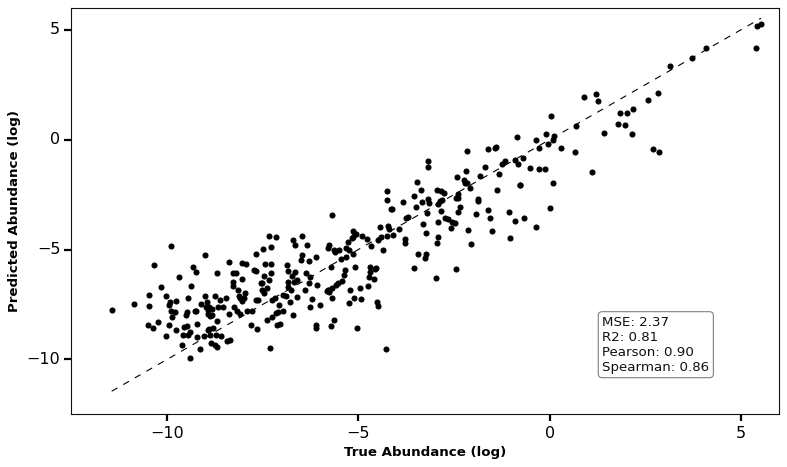

Model evaluation for Bovine SP Intensity is complete!


In [ ]:
def predict_file(train_file, test_file, name):
    # Initialize a RandomForestRegressor model with 100 estimators
    model = RandomForestRegressor(n_estimators=100, random_state=42)

    # Read the input training DataFrame
    df_train = pd.read_excel(train_file, header=0)

    # Filter out rows with abundance values below zero (assume missing or zero values)
    #Min_Abundance = df_train['Abundance'].drop_duplicates().nsmallest(2).iloc[-1]
    #df_train = df_train[df_train['Abundance'] >= Min_Abundance]

    # Log-transform the 'Abundance' target variable for training
    y_train = np.log2(df_train['Abundance'].to_numpy().astype(float))

    # Drop unnecessary columns in both training and test sets
    columns_to_drop = ['Abundance', 'NPUNID', 'Entry']
    df_train.drop(columns=[col for col in columns_to_drop if col in df_train.columns], inplace=True)

    # Read the input test DataFrame
    df_test = pd.read_excel(test_file, header=0)
    #Min_Abundance = df_test['Abundance'].drop_duplicates().nsmallest(2).iloc[-1]
    #df_test = df_test[df_test['Abundance'] >= Min_Abundance]

    # Log-transform the 'Abundance' target variable for testing
    y_test = np.log2(df_test['Abundance'].to_numpy().astype(float))

    selected_features = df_train.columns

    X_train = df_train[selected_features].copy()
    X_test = df_test[selected_features].copy()

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    pearson, _ = pearsonr(y_test, y_pred)
    spearman, _ = spearmanr(y_test, y_pred)
    r_squared = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)

    print("Pearson:", pearson)
    print("Spearman:", spearman)
    print("R-squared:", r_squared)
    print("Mean Squared Error:", mse)

    # Create a scatter plot of true vs predicted values
    plt.style.use('classic')

    # Create the figure and axes object with specific figure size and background color
    fig, ax = plt.subplots(figsize=(10, 6), facecolor='white')

    # Set the figure resolution
    plt.rcParams['figure.dpi'] = 300

    # Plotting the scatter data with customized color and plot line for identity
    ax.scatter(y_test, y_pred, color='black', s=20)  # Adjust marker size with `s`
    ax.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='black')  # Identity line

    # Setting labels and title with customized options
    ax.set_xlabel('True Abundance (log2)', fontweight='bold', color='black')
    ax.set_ylabel('Predicted Abundance (log2)', fontweight='bold', color='black')

    # Setting plot title
    #ax.set_title(f'RFR Model: Predicted vs True Abundance (Log) Bov Swiss-Prot Intensity', fontweight='bold', color='black')

    # Adjusting the tick parameters to match the RFC plot style
    ax.tick_params(axis='both', which='both', direction='out',
               length=6, width=2, colors='black',
               labelsize='large', labelcolor='black',
               bottom=True, top=False, left=True, right=False)
    ax.set_xlim(left=-12.5, right=6)
    ax.set_ylim(bottom=-12.5, top=6)

    # Add a metrics box to the plot
    box_text = f"MSE: {mse:.2f}\nR2: {r_squared:.2f}\nPearson: {pearson:.2f}\nSpearman: {spearman:.2f}"
    props = dict(boxstyle='round', facecolor='white', alpha=0.5, edgecolor='black')
    ax.text(0.75, 0.10, box_text, transform=ax.transAxes, fontsize=12, verticalalignment='bottom', bbox=props)

    # Remove grid lines
    ax.grid(False)

    # Ensure the layout fits the plot and no clipping occurs
    plt.tight_layout()

    # Display the plot
    plt.show()

    # Save the plot
    #plt.savefig(f'{name}_RFR_Pred_vs_True_.png')

    # Close the plot explicitly to free up memory
    plt.close()

    # Save the evaluation metrics (you can add logic here to save it to an Excel file if needed)

    print(f"Model evaluation for {name} is complete!")


# Call the function for a single file without threading
predict_file('/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFR/df_RFECV_RFR_Bov SP Intensity training_data_original.xlsx', '/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Input_DataFrames/post_clean_up_dfs/RFR/test_data_Bov SP Intensity_original.xlsx', 'Bovine SP Intensity')


### Extracting Predicted vs True Abundances (log2) for a subset of Proteins

Pearson: 0.9002003137473914
Spearman: 0.8601429238910325
R-squared: 0.8076928863512441
Mean Squared Error: 2.3703392782441255
Predictions saved to /content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFR/protein_abundance_predictions_comparison_withSampleNum.xlsx


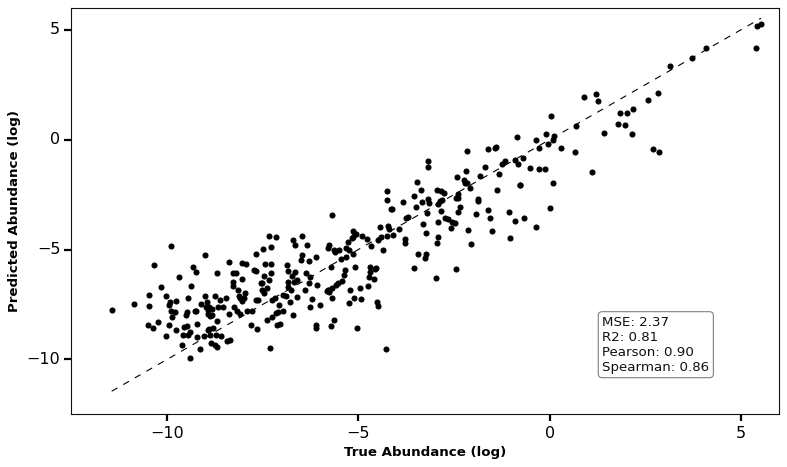

Model evaluation for Bovine SP Intensity is complete!


In [ ]:
def predict_file(train_file, test_file, name):
    # Initialize a RandomForestRegressor model with 100 estimators
    model = RandomForestRegressor(n_estimators=100, random_state=42)

    # Read the input training DataFrame
    df_train = pd.read_excel(train_file, header=0)

    # Log-transform the 'Abundance' target variable for training
    y_train = np.log2(df_train['Abundance'].to_numpy().astype(float))

    # Drop unnecessary columns in both training and test sets
    columns_to_drop = ['Abundance', 'NPUNID', 'Entry']
    df_train.drop(columns=[col for col in columns_to_drop if col in df_train.columns], inplace=True)

    # Read the input test DataFrame
    df_test = pd.read_excel(test_file, header=0)

    # Log-transform the 'Abundance' target variable for testing
    y_test = np.log2(df_test['Abundance'].to_numpy().astype(float))

    # Store relevant columns: proteins and sample identifiers
    proteins = df_test['Entry'] if 'Entry' in df_test.columns else None
    sample_num = df_test['Sample_num'] if 'Sample_num' in df_test.columns else None

    selected_features = df_train.columns

    X_train = df_train[selected_features].copy()
    X_test = df_test[selected_features].copy()

    # Fit the model and make predictions
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    pearson, _ = pearsonr(y_test, y_pred)
    spearman, _ = spearmanr(y_test, y_pred)
    r_squared = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)

    print("Pearson:", pearson)
    print("Spearman:", spearman)
    print("R-squared:", r_squared)
    print("Mean Squared Error:", mse)

    # Save true and predicted abundance values along with Sample_num to an Excel file
    results = pd.DataFrame({
        'Sample_num': sample_num,  # NP identifier
        'Protein': proteins,       # Protein identifiers
        'True Abundance (log)': y_test,
        'Predicted Abundance (log)': y_pred
    })

    output_path = '/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFR/protein_abundance_predictions_comparison_withSampleNum.xlsx'
    results.to_excel(output_path, index=False)
    print(f"Predictions saved to {output_path}")

    # Create the scatter plot (as in your existing code)
    plt.style.use('classic')
    fig, ax = plt.subplots(figsize=(10, 6), facecolor='white')
    plt.rcParams['figure.dpi'] = 300
    ax.scatter(y_test, y_pred, color='black', s=20)
    ax.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='black')
    ax.set_xlabel('True Abundance (log2)', fontweight='bold', color='black')
    ax.set_ylabel('Predicted Abundance (log2)', fontweight='bold', color='black')
    ax.tick_params(axis='both', which='both', direction='out', length=6, width=2, colors='black',
                   labelsize='large', labelcolor='black', bottom=True, top=False, left=True, right=False)
    ax.set_xlim(left=-12.5, right=6)
    ax.set_ylim(bottom=-12.5, top=6)
    box_text = f"MSE: {mse:.2f}\nR2: {r_squared:.2f}\nPearson: {pearson:.2f}\nSpearman: {spearman:.2f}"
    props = dict(boxstyle='round', facecolor='white', alpha=0.5, edgecolor='black')
    ax.text(0.75, 0.10, box_text, transform=ax.transAxes, fontsize=12, verticalalignment='bottom', bbox=props)
    ax.grid(False)
    plt.tight_layout()
    plt.show()
    plt.close()

    print(f"Model evaluation for {name} is complete!")


# Call the function for a single file without threading
predict_file('/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFR/df_RFECV_RFR_Bov SP Intensity training_data_original.xlsx', '/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Input_DataFrames/post_clean_up_dfs/RFR/test_data_Bov SP Intensity_original.xlsx', 'Bovine SP Intensity')



## NP-Specific Predictions

[18, 22, 20, 29, 23, 27, 31, 19, 28, 35, 34, 26, 25, 32, 21, 24, 33, 30, 17]


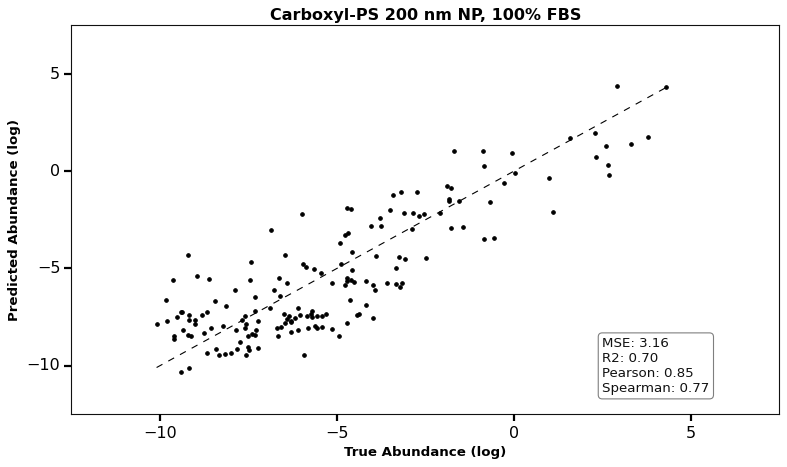

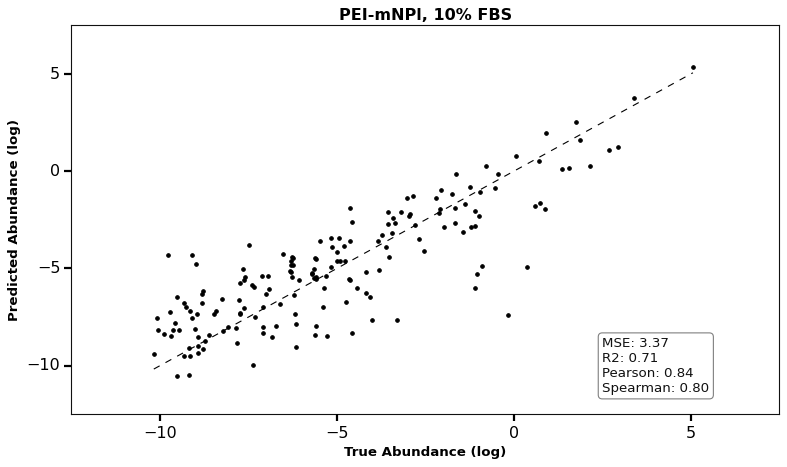

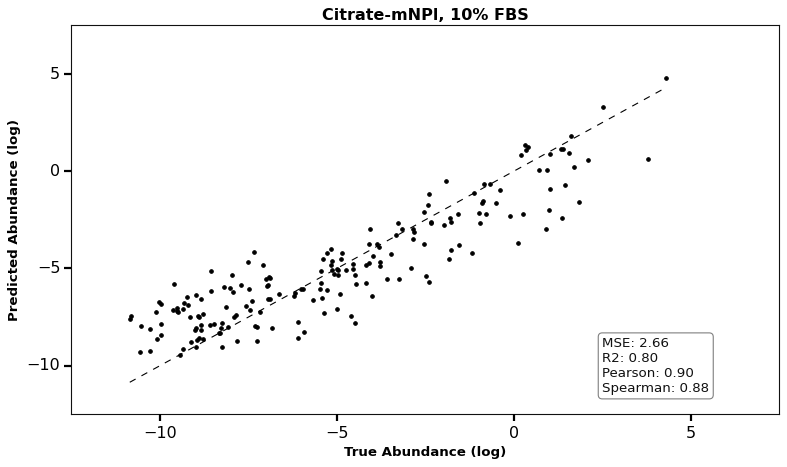

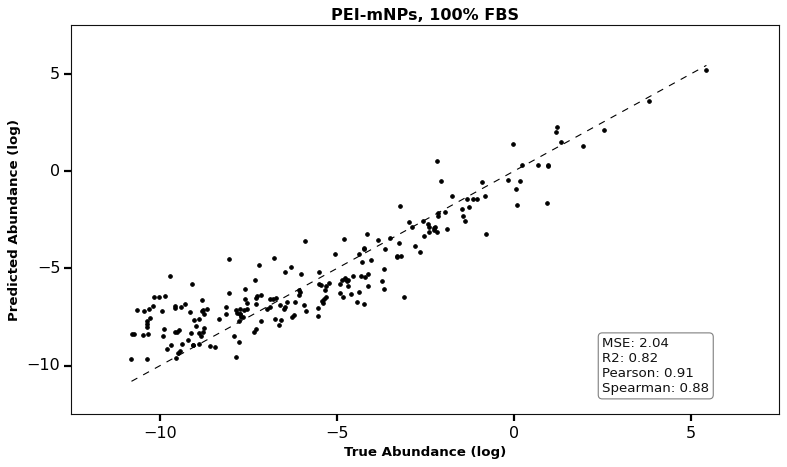

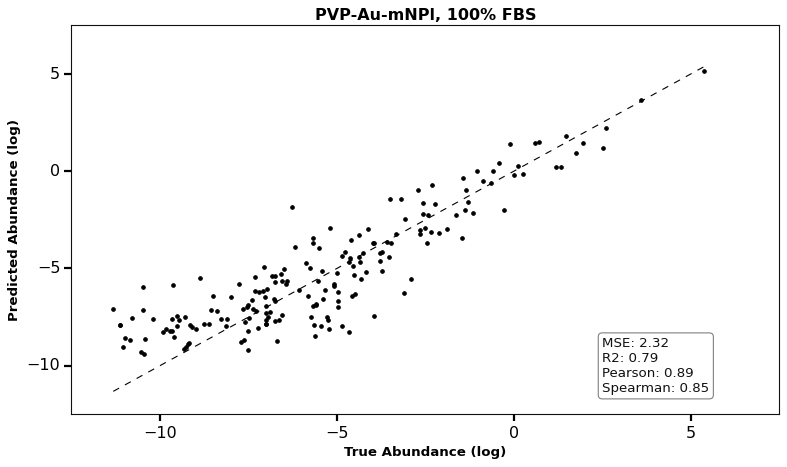

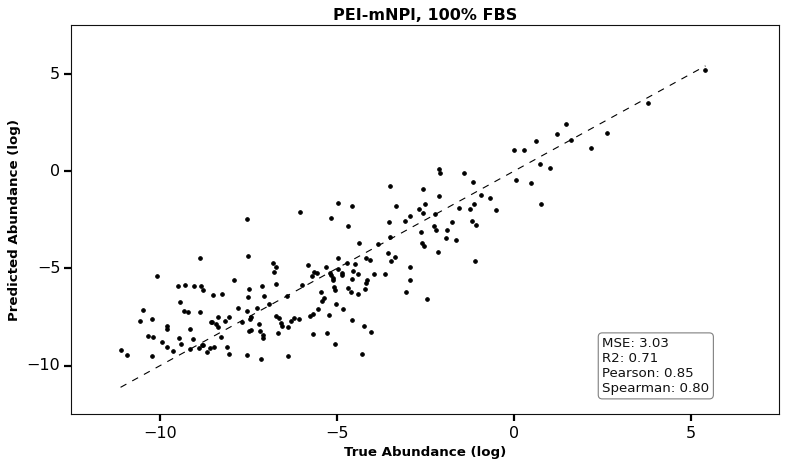

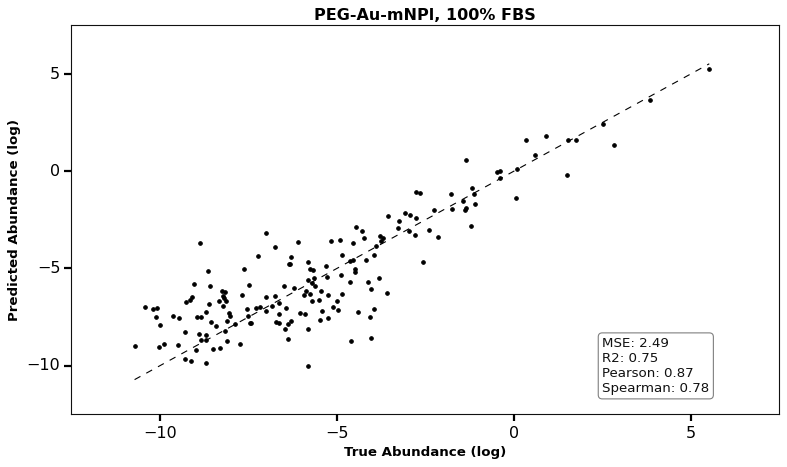

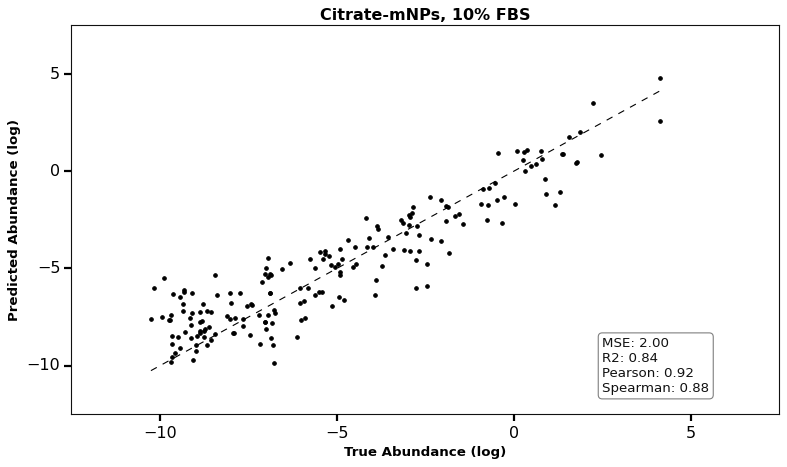

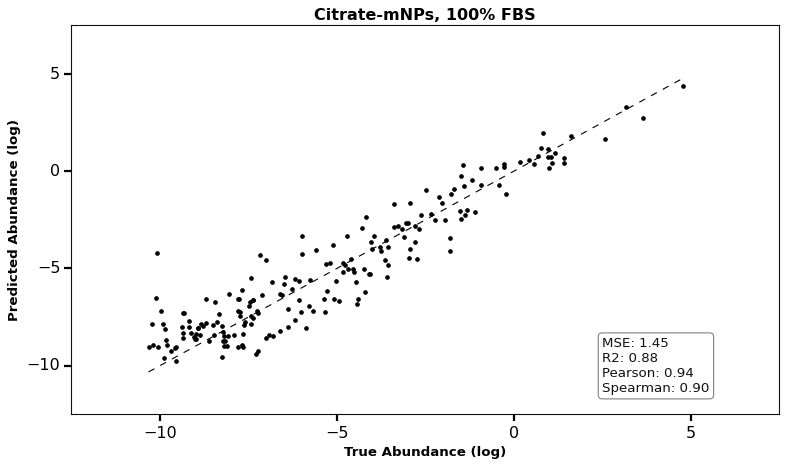

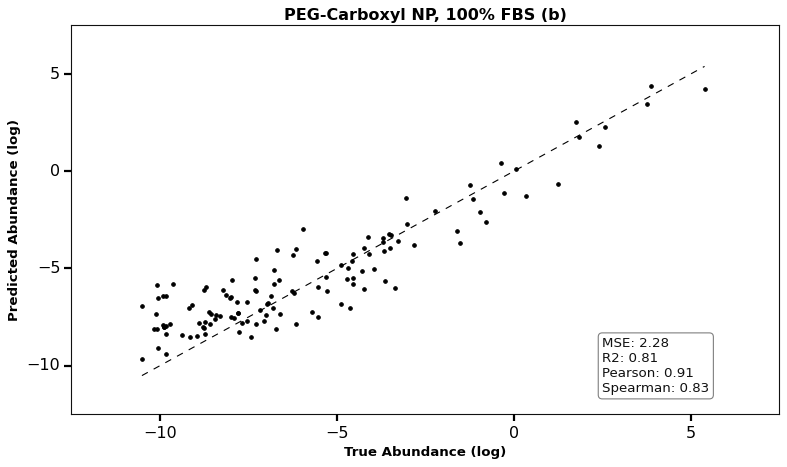

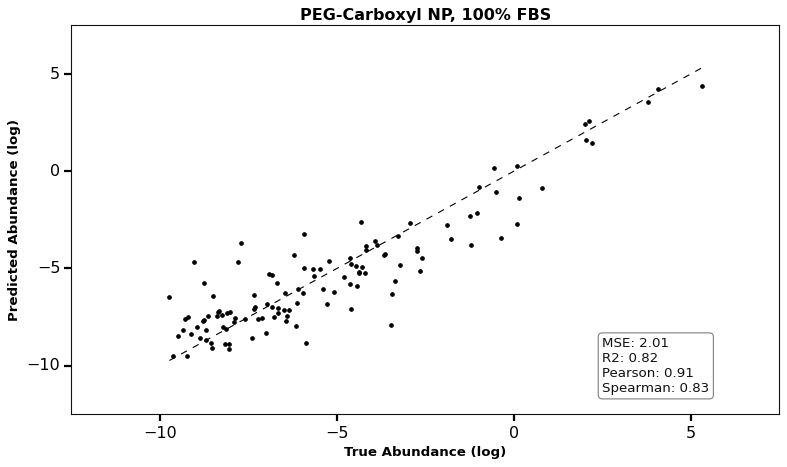

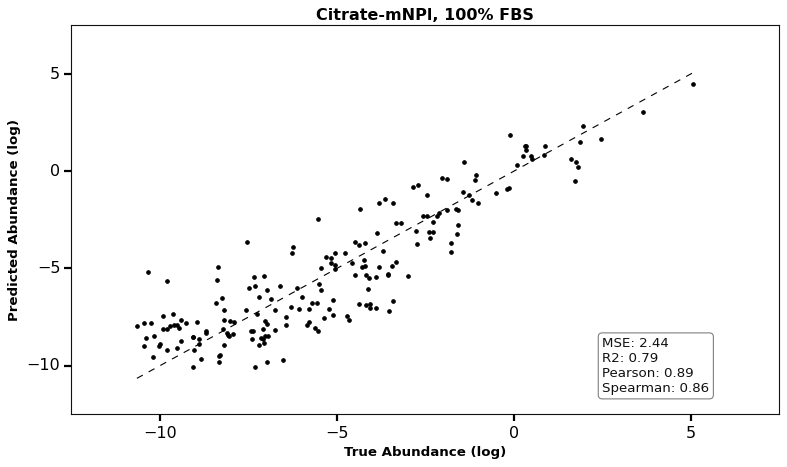

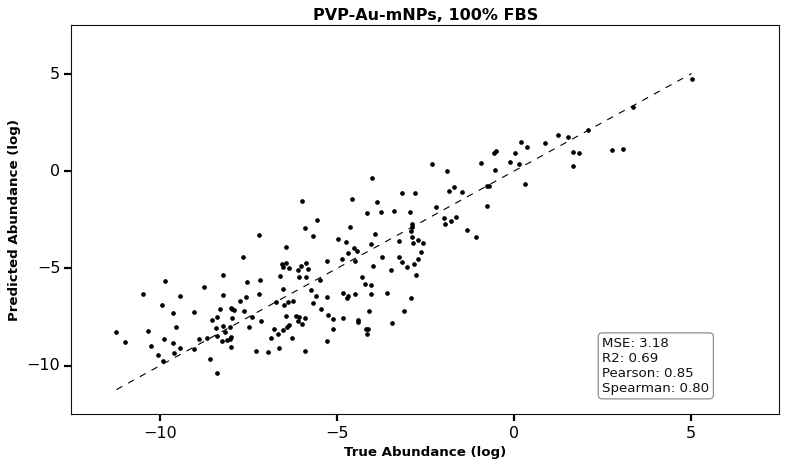

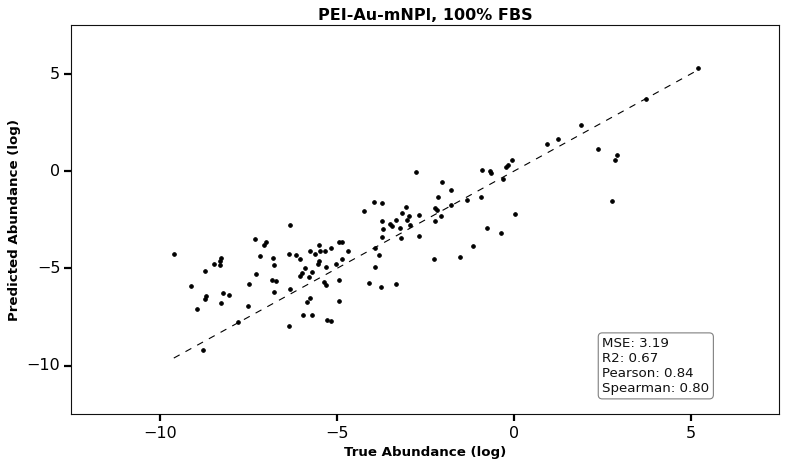

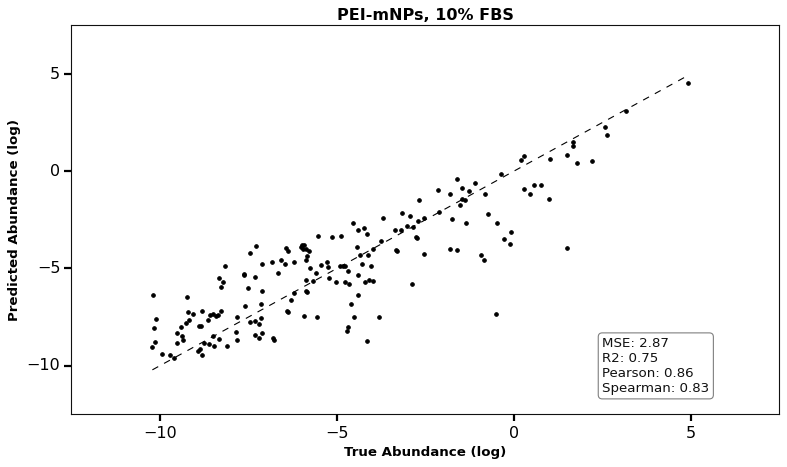

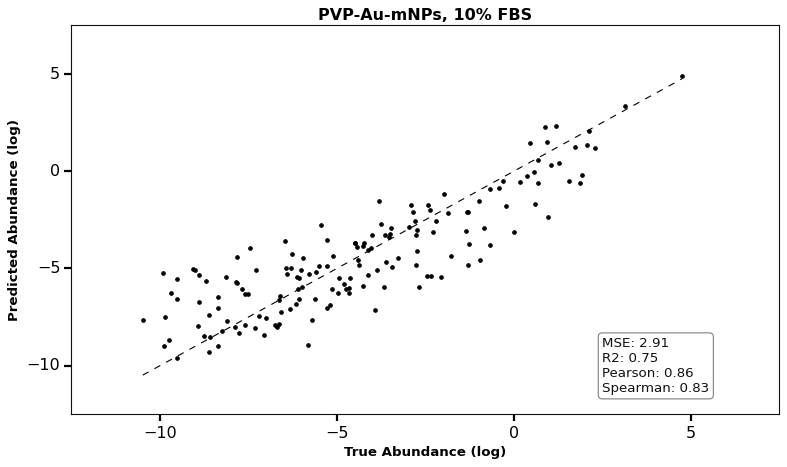

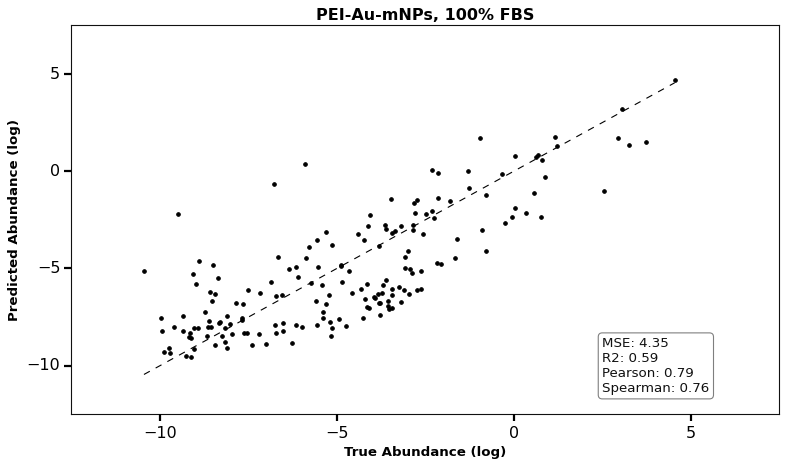

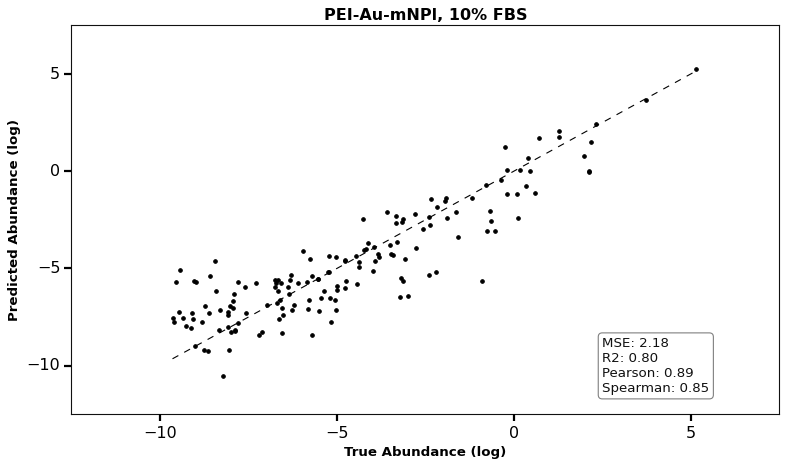

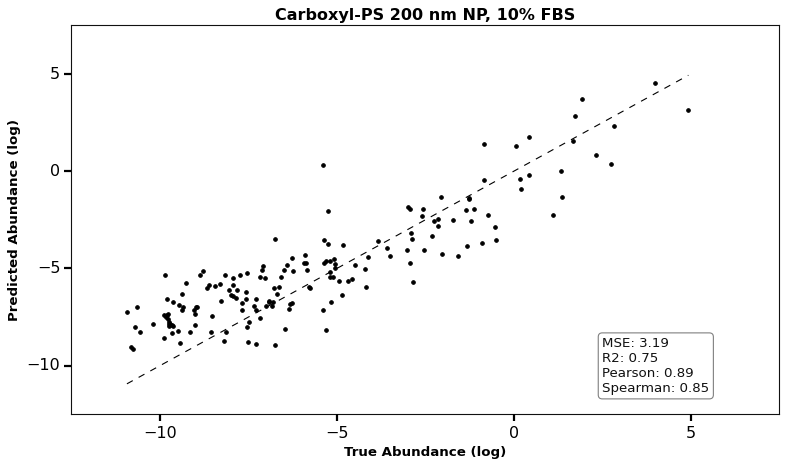

    Pearson  Spearman  R-squared  Mean Squared Error  \
0  0.850721  0.766766   0.699149            3.159681   
0  0.842564  0.798237   0.705976            3.367872   
0  0.901248  0.881619   0.800920            2.657632   
0  0.911564  0.877573   0.822042            2.042275   
0  0.892352  0.846536   0.790789            2.322043   

                                ID  
0  Carboxyl-PS 200 nm NP, 100% FBS  
0                PEI-mNPl, 10% FBS  
0            Citrate-mNPl, 10% FBS  
0               PEI-mNPs, 100% FBS  
0            PVP-Au-mNPl, 100% FBS  


In [ ]:
npunid_to_full_name = {
    17: "Carboxyl-PS 200 nm NP, 10% FBS",
    18: "Carboxyl-PS 200 nm NP, 100% FBS",
    19: "Citrate-mNPs, 10% FBS",
    20: "Citrate-mNPl, 10% FBS",
    21: "PEI-mNPs, 10% FBS",
    22: "PEI-mNPl, 10% FBS",
    23: "PVP-Au-mNPl, 100% FBS",
    24: "PVP-Au-mNPs, 10% FBS",
    25: "PVP-Au-mNPs, 100% FBS",
    26: "Citrate-mNPl, 100% FBS",
    27: "PEI-mNPl, 100% FBS",
    28: "Citrate-mNPs, 100% FBS",
    29: "PEI-mNPs, 100% FBS",
    30: "PEI-Au-mNPl, 10% FBS",
    31: "PEG-Au-mNPl, 100% FBS",
    32: "PEI-Au-mNPl, 100% FBS",
    33: "PEI-Au-mNPs, 100% FBS",
    34: "PEG-Carboxyl NP, 100% FBS",
    35: "PEG-Carboxyl NP, 100% FBS (b)"
}

def predict_nanoparticles(train_set, test_set, name):
    # Initialize a RandomForestRegressor model with 100 estimators
    model = RandomForestRegressor(n_estimators=100)

    # Filter out rows with abundance values below zero for train_set
    Min_Abundance = train_set['Abundance'].drop_duplicates().nsmallest(2).iloc[-1]
    train_set = train_set[train_set['Abundance'] >= Min_Abundance].copy()

    # X is df and y is 'Abundance' column in df
    # 'Abundance' column in df represents a 1D array of target values (class labels)
    label_train = np.log2(train_set['Abundance'].to_numpy().astype(float))

    # Remove unnecessary columns
    columns_to_drop = [col for col in ['Abundance', 'NPUNID', 'Entry'] if col in train_set.columns]
    train_set.drop(columns=columns_to_drop, inplace=True)
    selected_features = train_set.columns.tolist()

    # Filter out rows with abundance values below zero for test_set
    Min_Abundance = test_set['Abundance'].drop_duplicates().nsmallest(2).iloc[-1]
    test_set = test_set[test_set['Abundance'] >= Min_Abundance].copy()

    label_pred = np.log2(test_set['Abundance'].to_numpy().astype(float))

    X_train = train_set[selected_features].copy()
    X_test = test_set[selected_features].copy()
    y_train = label_train
    y_test = label_pred

    # Train the classifier
    model.fit(X_train, y_train)

    # Evaluate on validation set
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    pearson, _ = pearsonr(y_test, y_pred)
    spearman, _ = spearmanr(y_test, y_pred)
    r_squared = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)

    # Create a scatter plot of true vs predicted values
    plt.style.use('classic')

    # Creating the figure and axes object with a specified size and background color
    fig, ax = plt.subplots(figsize=(10, 6), facecolor='white')

    # Set high resolution for clearer output
    plt.rcParams['figure.dpi'] = 300

    # Scatter plot of true vs. predicted values using adjusted color and marker size
    ax.scatter(y_test, y_pred, color='black', s=10)  # Using black for consistency and adjusting marker size

    # Identity line with adjusted color and line style
    ax.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='black')

    # Setting labels, title with customized options
    ax.set_xlabel('True Abundance (log2)', fontweight='bold', color='black')
    ax.set_ylabel('Predicted Abundance (log2)', fontweight='bold', color='black')
    ax.set_title(f"{name}", fontweight='bold', color='black')
    ax.set_xlim(left=-12.5, right=7.5)
    ax.set_ylim(bottom=-12.5, top=7.5)

    # Add a metrics box to the plot with consistent styling
    box_text = f"MSE: {mse:.2f}\nR2: {r_squared:.2f}\nPearson: {pearson:.2f}\nSpearman: {spearman:.2f}"
    props = dict(boxstyle='round', facecolor='white', edgecolor='black', alpha=0.5)
    ax.text(0.75, 0.05, box_text, transform=ax.transAxes, fontsize=12, verticalalignment='bottom', bbox=props)

    # Adjusting the tick parameters for consistency
    ax.tick_params(axis='both', which='both', direction='out',
                   length=6, width=2, colors='black',
                   labelsize='large', labelcolor='black',
                   bottom=True, top=False, left=True, right=False)

    # Remove grid lines for a cleaner look
    ax.grid(False)

    # Ensure layout fits the plot and no clipping occurs
    plt.tight_layout()

    # Display the plot
    plt.show()

    # Close the plot explicitly to free up memory
    plt.close()

    results = pd.DataFrame({
        "Pearson": [pearson],
        "Spearman": [spearman],
        "R-squared": [r_squared],
        "Mean Squared Error": [mse],
        "ID": name  # This assumes 'name' is intended to be the identifier for the row
    })


    return results



# Manually selected file for 1) original (cleaned) df and 2) RFR RFECV results (to get best_features)
original_df = '/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Input_DataFrames/post_clean_up_dfs/RFR/df_Bov Swiss Intensity _original.xlsx'
feats_from_rfr_rfecv = '/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFR/df_RFECV_RFR_Bov SP Intensity training_data_original.xlsx'

df = pd.read_excel(original_df, header=0)
df_feats = pd.read_excel(feats_from_rfr_rfecv, header=0)

# Extract the list of column names from df_feats
# Assuming df_feats has a column called 'Features' or similar that contains the feature names
feats_columns = df_feats.columns.tolist()

# Filter df to only include the columns that match feats_columns, making a copy
df_filtered = df[feats_columns].copy()
# Create new evaluation df that will have the results of everything appended to it
full_eval = pd.DataFrame()

# Create a list of all unique NPUNID IDs in current df
np_ids = df['NPUNID'].unique().tolist()
print(np_ids)



for np_id in np_ids:
    # Filter df to only include rows with current NPUNID - test set
    current_np = df_filtered.loc[df['NPUNID'] == np_id].copy()
    # Filter df to only include rows without current NPUNID - train set
    temp_df = df_filtered.loc[df['NPUNID'] != np_id].copy()

    # Get full sample name
    full_name = npunid_to_full_name.get(np_id, f'ID: {np_id}')

    # Train RFR model to make predictions on current NPUNID entry
    eval = predict_nanoparticles(temp_df, current_np, full_name)

    # Append the test to the full evaluation df
    full_eval = pd.concat([full_eval, eval])

print(full_eval.head())

## NP-Specific Abundance Predicted vs True (log2) data values

Saved parity plot data for Carboxyl-PS 200 nm NP, 100% FBS to /content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFR/Carboxyl-PS 200 nm NP, 100% FBS_parity_plot_data.xlsx


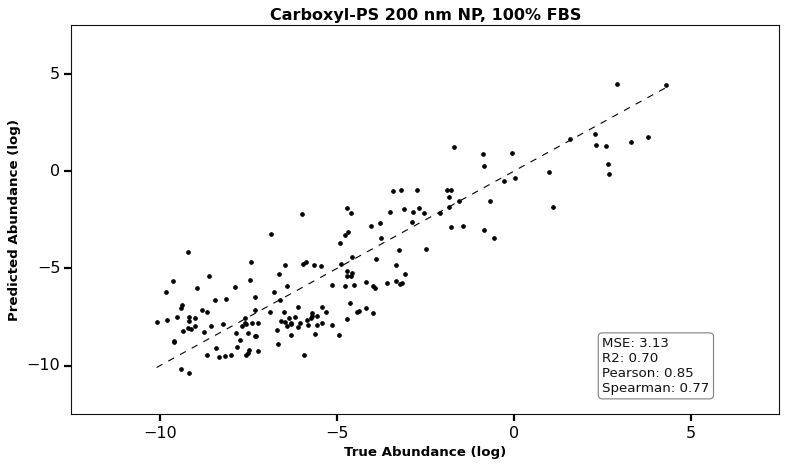

Saved parity plot data for PEI-mNPl, 10% FBS to /content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFR/PEI-mNPl, 10% FBS_parity_plot_data.xlsx


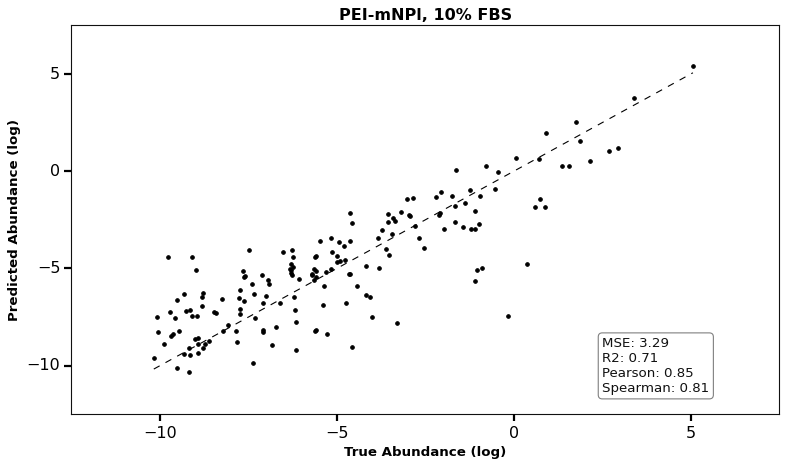

Saved parity plot data for Citrate-mNPl, 10% FBS to /content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFR/Citrate-mNPl, 10% FBS_parity_plot_data.xlsx


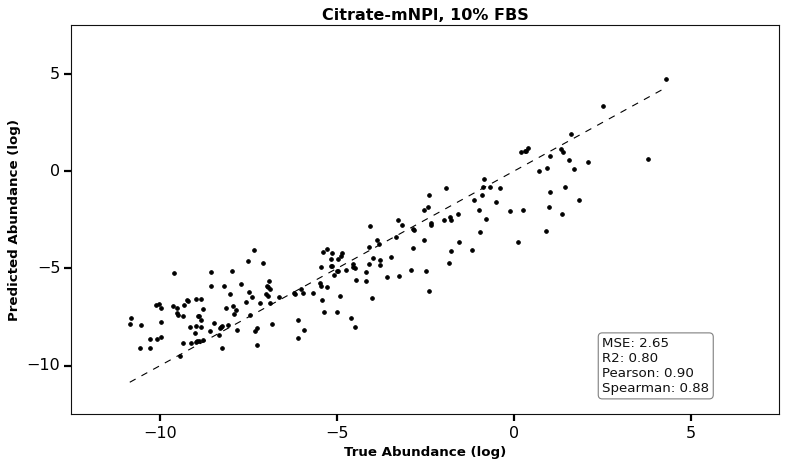

Saved parity plot data for PEI-mNPs, 100% FBS to /content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFR/PEI-mNPs, 100% FBS_parity_plot_data.xlsx


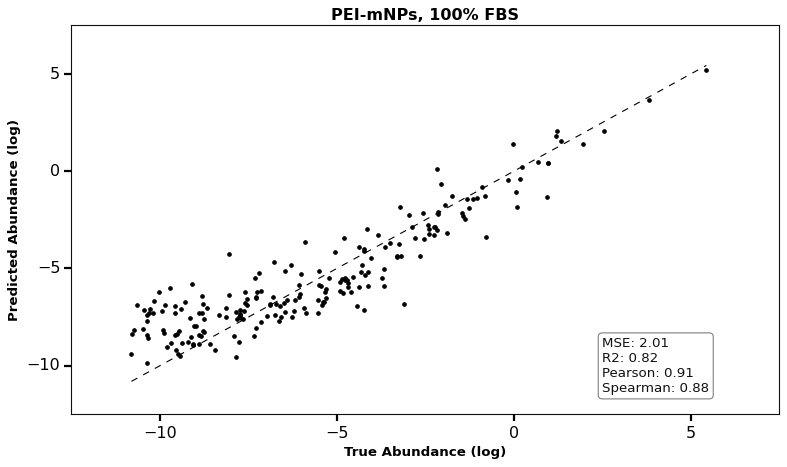

Saved parity plot data for PVP-Au-mNPl, 100% FBS to /content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFR/PVP-Au-mNPl, 100% FBS_parity_plot_data.xlsx


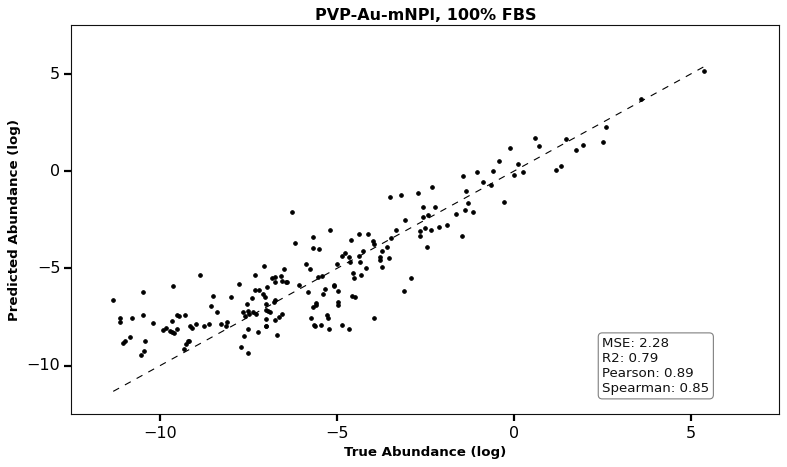

Saved parity plot data for PEI-mNPl, 100% FBS to /content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFR/PEI-mNPl, 100% FBS_parity_plot_data.xlsx


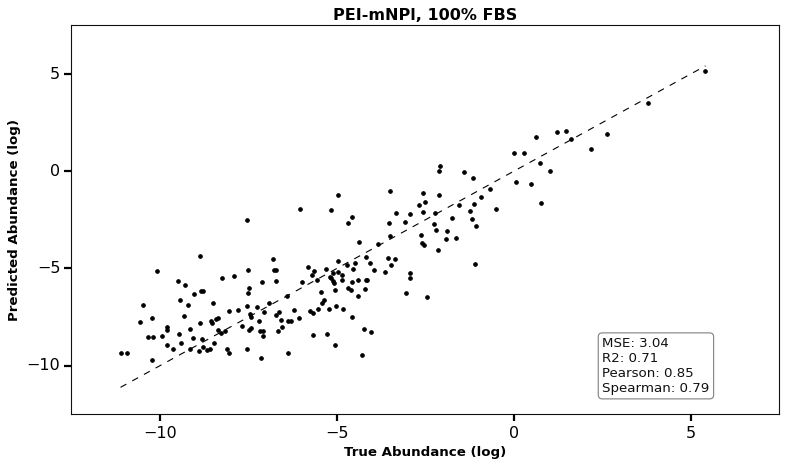

Saved parity plot data for PEG-Au-mNPl, 100% FBS to /content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFR/PEG-Au-mNPl, 100% FBS_parity_plot_data.xlsx


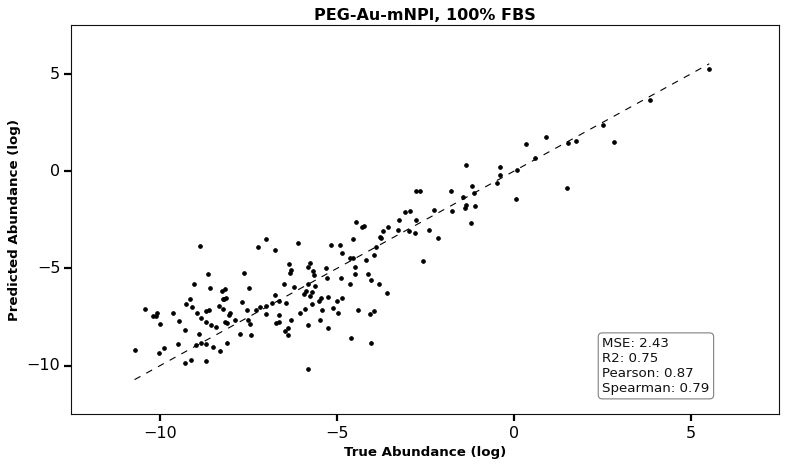

Saved parity plot data for Citrate-mNPs, 10% FBS to /content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFR/Citrate-mNPs, 10% FBS_parity_plot_data.xlsx


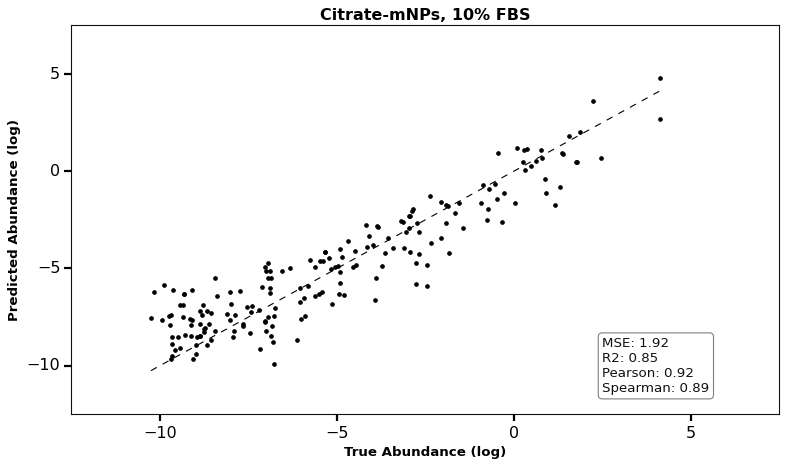

Saved parity plot data for Citrate-mNPs, 100% FBS to /content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFR/Citrate-mNPs, 100% FBS_parity_plot_data.xlsx


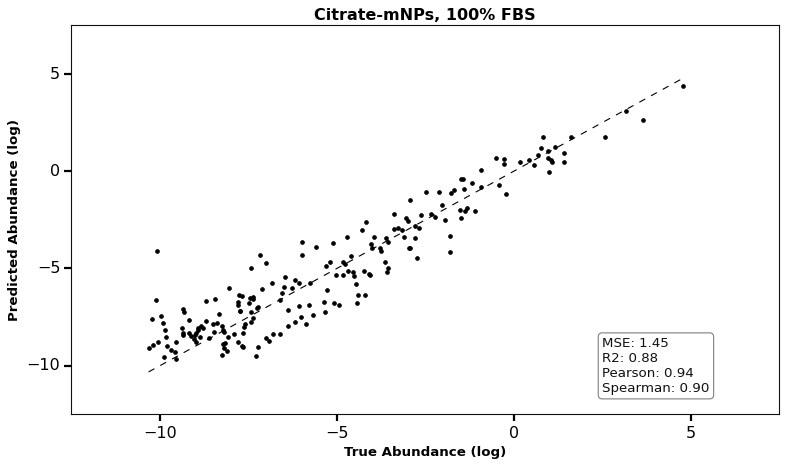

Saved parity plot data for PEG-Carboxyl NP, 100% FBS (b) to /content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFR/PEG-Carboxyl NP, 100% FBS (b)_parity_plot_data.xlsx


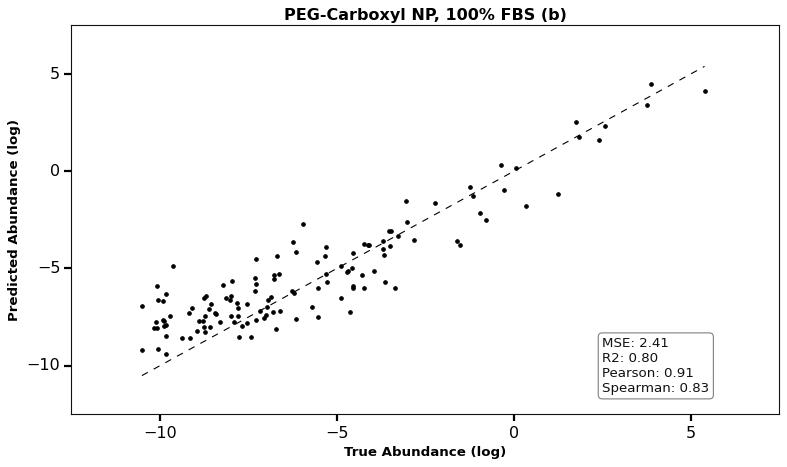

Saved parity plot data for PEG-Carboxyl NP, 100% FBS to /content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFR/PEG-Carboxyl NP, 100% FBS_parity_plot_data.xlsx


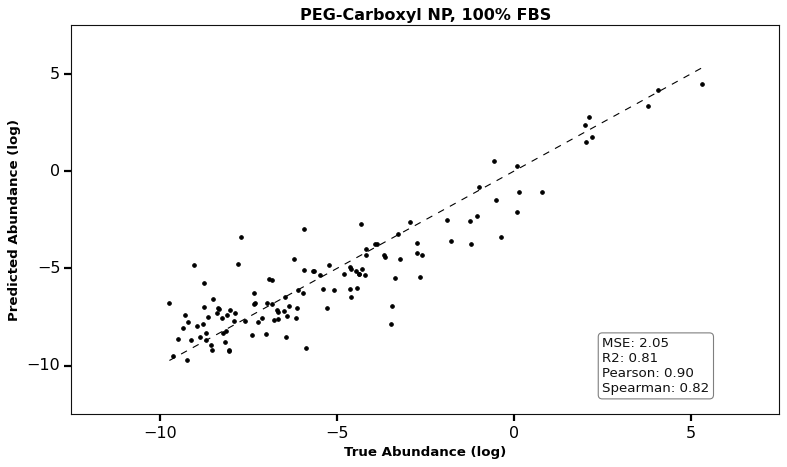

Saved parity plot data for Citrate-mNPl, 100% FBS to /content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFR/Citrate-mNPl, 100% FBS_parity_plot_data.xlsx


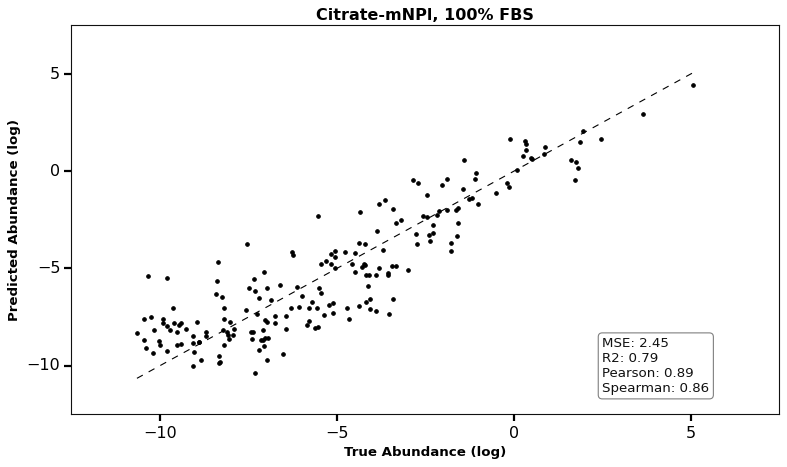

Saved parity plot data for PVP-Au-mNPs, 100% FBS to /content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFR/PVP-Au-mNPs, 100% FBS_parity_plot_data.xlsx


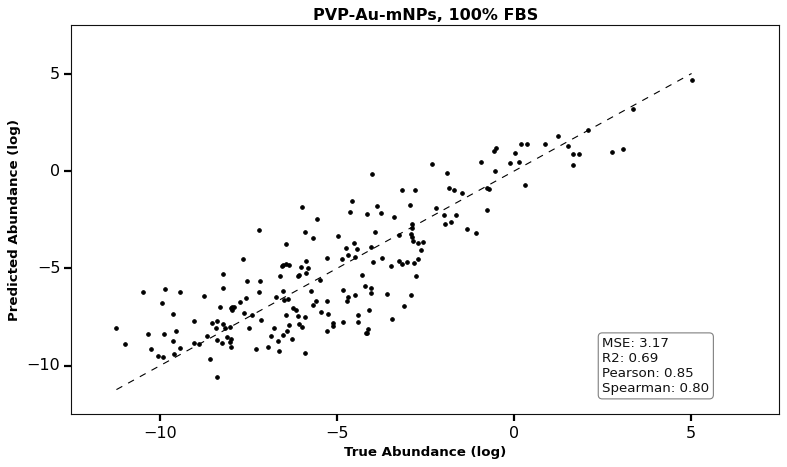

Saved parity plot data for PEI-Au-mNPl, 100% FBS to /content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFR/PEI-Au-mNPl, 100% FBS_parity_plot_data.xlsx


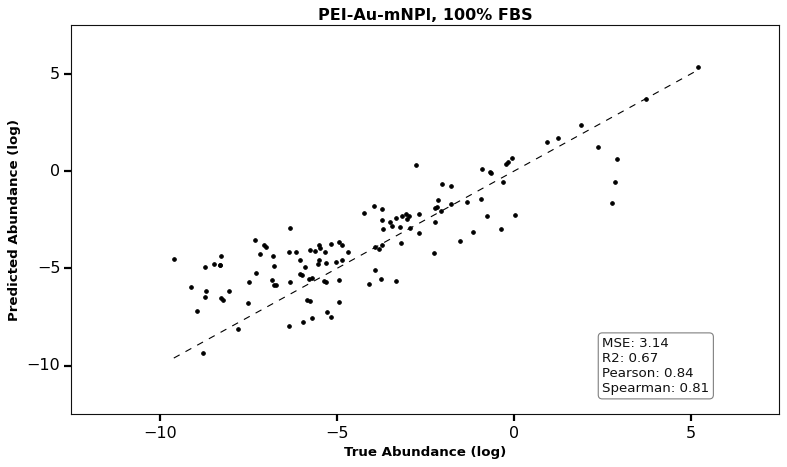

Saved parity plot data for PEI-mNPs, 10% FBS to /content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFR/PEI-mNPs, 10% FBS_parity_plot_data.xlsx


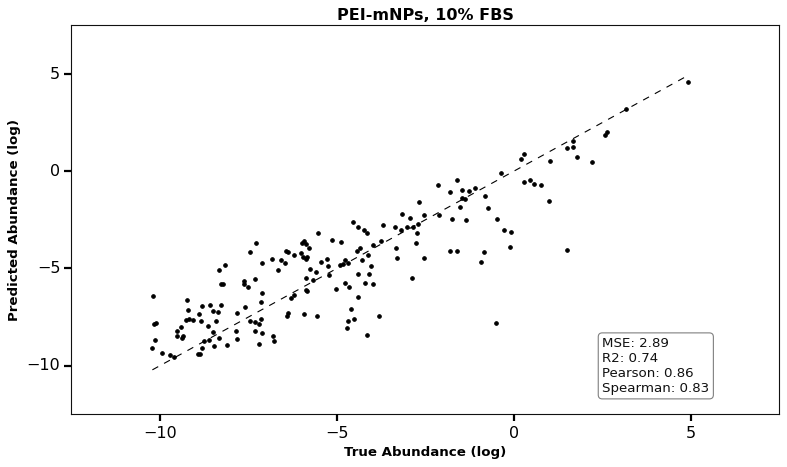

Saved parity plot data for PVP-Au-mNPs, 10% FBS to /content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFR/PVP-Au-mNPs, 10% FBS_parity_plot_data.xlsx


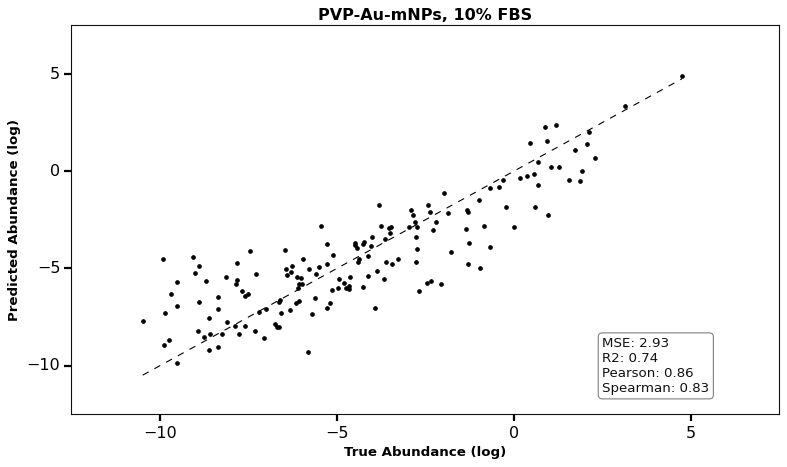

Saved parity plot data for PEI-Au-mNPs, 100% FBS to /content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFR/PEI-Au-mNPs, 100% FBS_parity_plot_data.xlsx


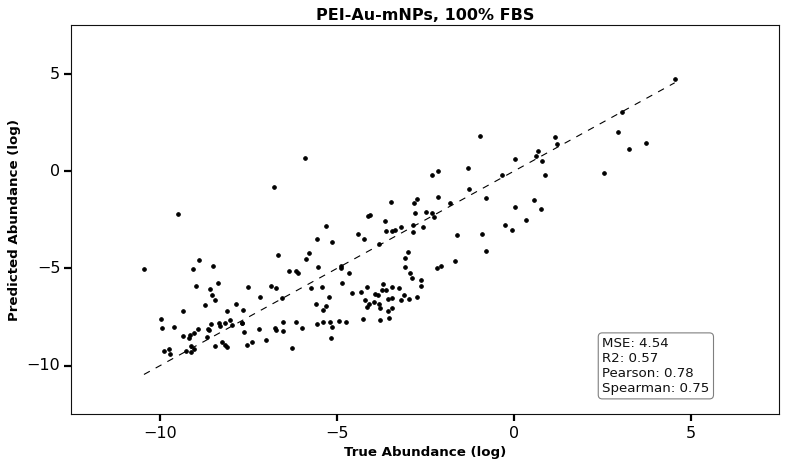

Saved parity plot data for PEI-Au-mNPl, 10% FBS to /content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFR/PEI-Au-mNPl, 10% FBS_parity_plot_data.xlsx


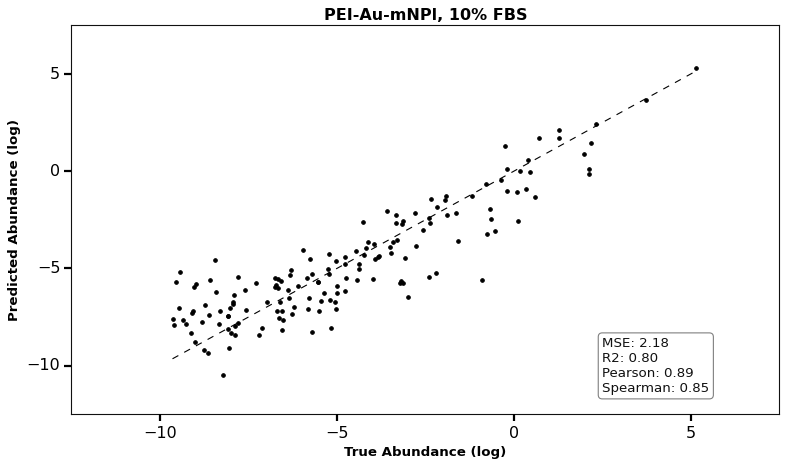

Saved parity plot data for Carboxyl-PS 200 nm NP, 10% FBS to /content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFR/Carboxyl-PS 200 nm NP, 10% FBS_parity_plot_data.xlsx


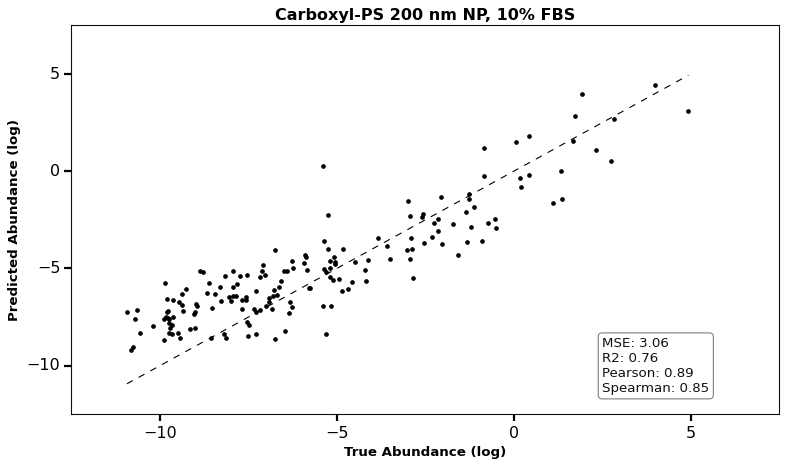

All NP parity data saved to All_NPs_Parity_Data.xlsx


In [ ]:
def predict_nanoparticles(train_set, test_set, name):
    # Initialize a RandomForestRegressor model with 100 estimators
    model = RandomForestRegressor(n_estimators=100, random_state=42)

    # Filter out rows with abundance values below zero for train_set
    Min_Abundance = train_set['Abundance'].drop_duplicates().nsmallest(2).iloc[-1]
    train_set = train_set[train_set['Abundance'] >= Min_Abundance].copy()

    # Log-transform the 'Abundance' column for training
    y_train = np.log2(train_set['Abundance'].to_numpy().astype(float))

    # Remove unnecessary columns
    columns_to_drop = ['Abundance', 'NPUNID', 'Entry']
    train_set.drop(columns=[col for col in columns_to_drop if col in train_set.columns], inplace=True)
    selected_features = train_set.columns.tolist()

    # Filter out rows with abundance values below zero for test_set
    Min_Abundance = test_set['Abundance'].drop_duplicates().nsmallest(2).iloc[-1]
    test_set = test_set[test_set['Abundance'] >= Min_Abundance].copy()

    # Log-transform the 'Abundance' column for testing
    y_test = np.log2(test_set['Abundance'].to_numpy().astype(float))

    # Extract metadata columns
    nps = test_set['NPUNID'] if 'NPUNID' in test_set.columns else None
    proteins = test_set['Entry'] if 'Entry' in test_set.columns else None

    # Prepare training and testing feature sets
    X_train = train_set[selected_features].copy()
    X_test = test_set[selected_features].copy()

    # Train the model
    model.fit(X_train, y_train)

    # Make predictions
    y_pred = model.predict(X_test)

    # Save results for individual proteins and nanoparticles
    results = pd.DataFrame({
        'NPUNID': nps,
        'Protein': proteins,
        'True Abundance (log)': y_test,
        'Predicted Abundance (log)': y_pred
    })

    # Save results to an Excel file
    output_file = f"/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFR/{name}_parity_plot_data.xlsx"
    results.to_excel(output_file, index=False)
    print(f"Saved parity plot data for {name} to {output_file}")

    # Calculate evaluation metrics
    pearson, _ = pearsonr(y_test, y_pred)
    spearman, _ = spearmanr(y_test, y_pred)
    r_squared = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)

    # Create a scatter plot of true vs predicted values
    plt.style.use('classic')
    fig, ax = plt.subplots(figsize=(10, 6), facecolor='white')
    plt.rcParams['figure.dpi'] = 300
    ax.scatter(y_test, y_pred, color='black', s=10)
    ax.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='black')
    ax.set_xlabel('True Abundance (log)', fontweight='bold', color='black')
    ax.set_ylabel('Predicted Abundance (log)', fontweight='bold', color='black')
    ax.set_title(f"{name}", fontweight='bold', color='black')
    ax.set_xlim(left=-12.5, right=7.5)
    ax.set_ylim(bottom=-12.5, top=7.5)
    box_text = f"MSE: {mse:.2f}\nR2: {r_squared:.2f}\nPearson: {pearson:.2f}\nSpearman: {spearman:.2f}"
    props = dict(boxstyle='round', facecolor='white', edgecolor='black', alpha=0.5)
    ax.text(0.75, 0.05, box_text, transform=ax.transAxes, fontsize=12, verticalalignment='bottom', bbox=props)
    ax.tick_params(axis='both', which='both', direction='out',
                   length=6, width=2, colors='black', labelsize='large', labelcolor='black',
                   bottom=True, top=False, left=True, right=False)
    ax.grid(False)
    plt.tight_layout()
    plt.show()
    plt.close()

    # Return results for further processing if needed
    return results


# Create an empty DataFrame for storing all results
full_eval = pd.DataFrame()

# Iterate through all unique NPUNID values
for np_id in np_ids:
    # Filter test and train sets
    current_np = df_filtered.loc[df['NPUNID'] == np_id].copy()
    temp_df = df_filtered.loc[df['NPUNID'] != np_id].copy()

    # Get the full name of the nanoparticle
    full_name = npunid_to_full_name.get(np_id, f'ID: {np_id}')

    # Train and predict
    predictions = predict_nanoparticles(temp_df, current_np, full_name)

    # Append predictions to the full evaluation DataFrame
    full_eval = pd.concat([full_eval, predictions])

# Save the combined results to an Excel file
full_eval.to_excel("/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFR/All_NPs_Parity_Data.xlsx", index=False)
print("All NP parity data saved to All_NPs_Parity_Data.xlsx")


# Old Code

[18, 22, 20, 29, 23, 27, 31, 19, 28, 35, 34, 26, 25, 32, 21, 24, 33, 30, 17]


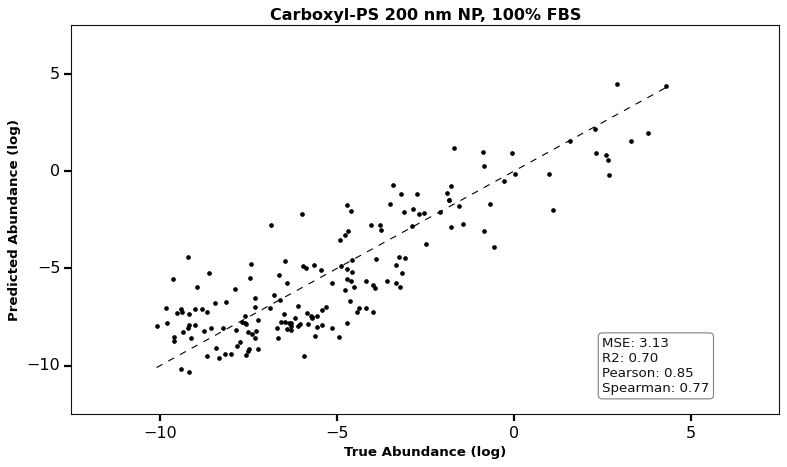

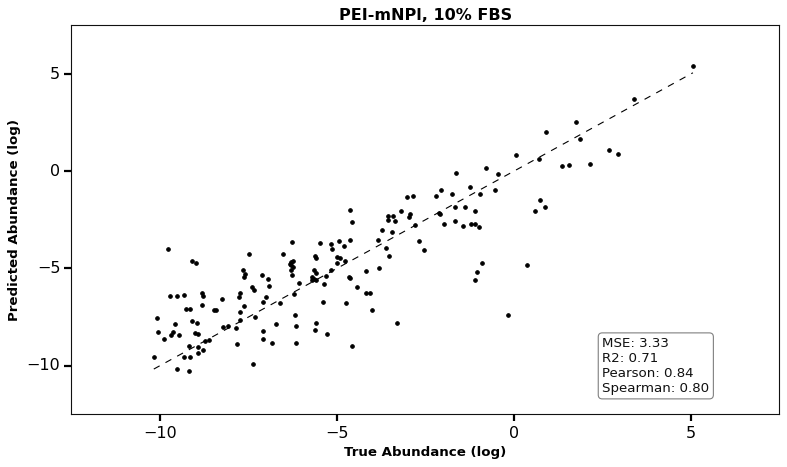

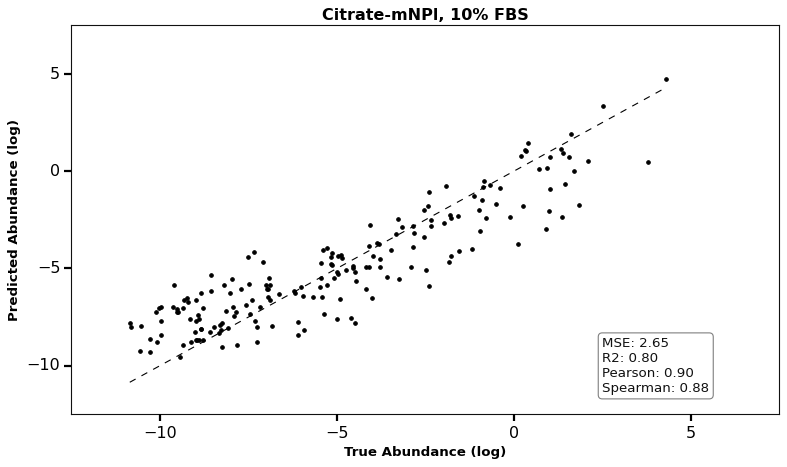

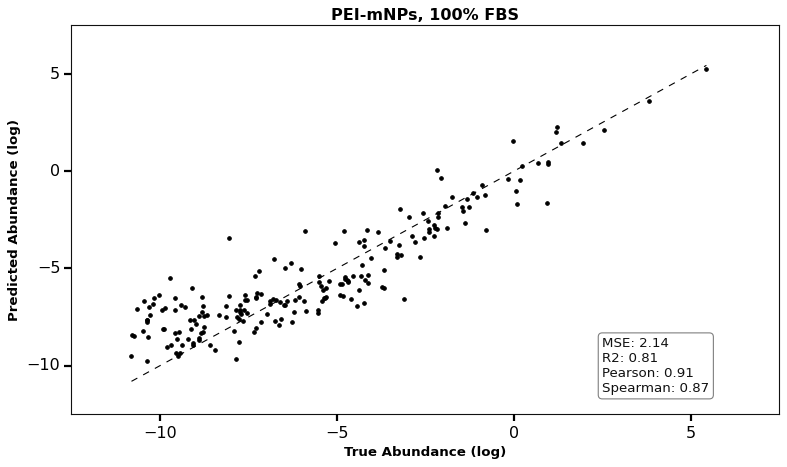

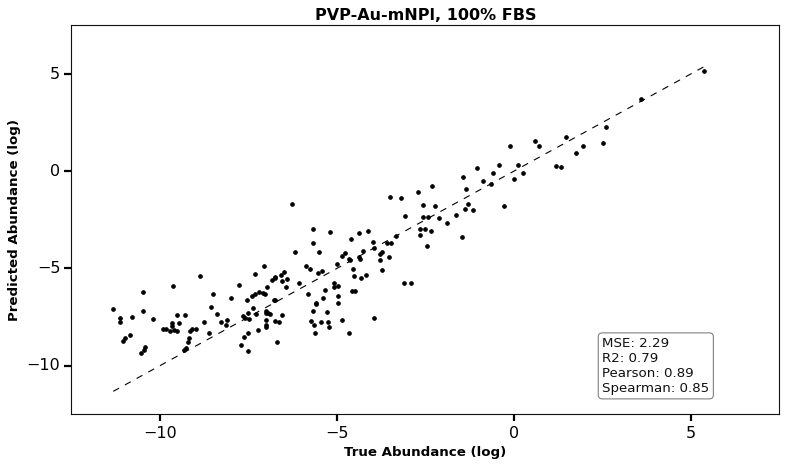

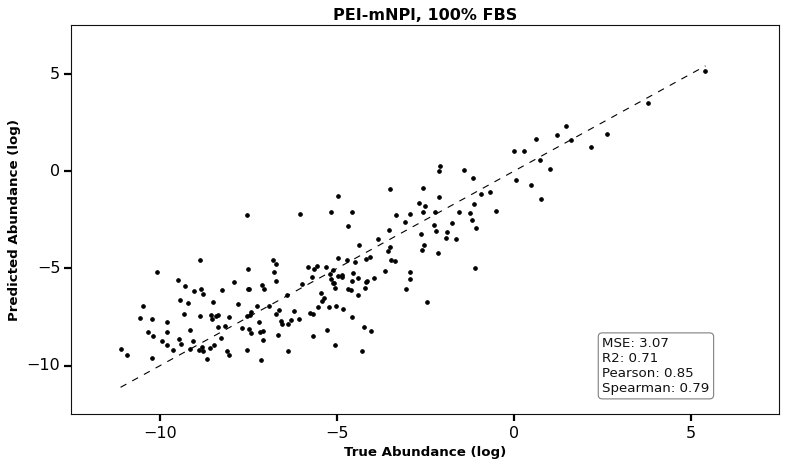

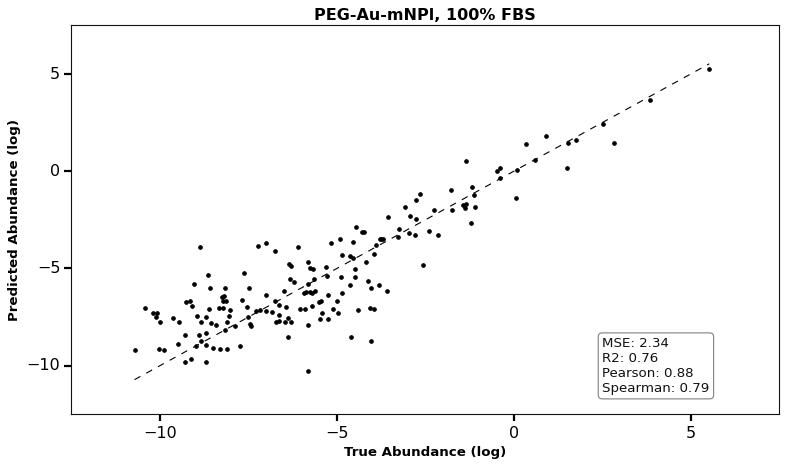

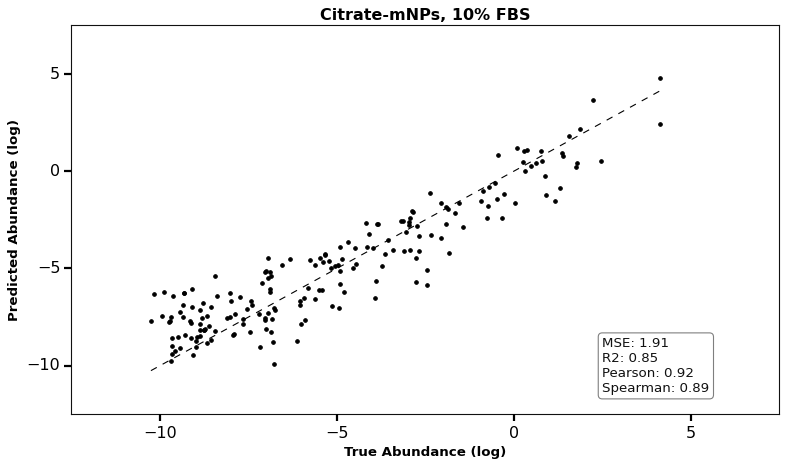

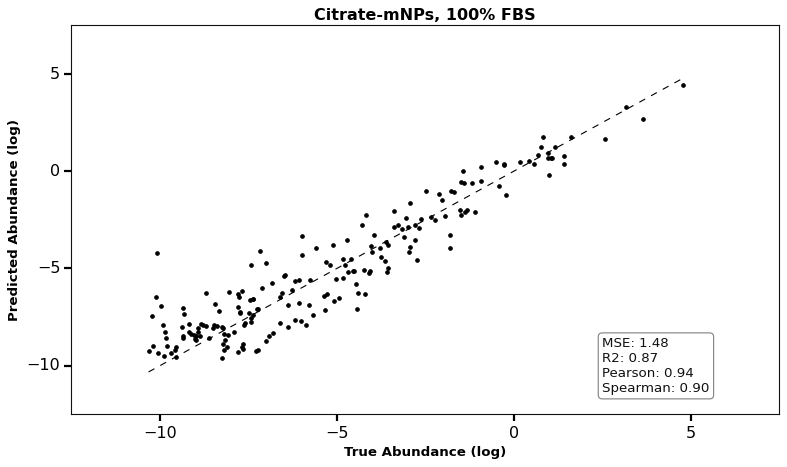

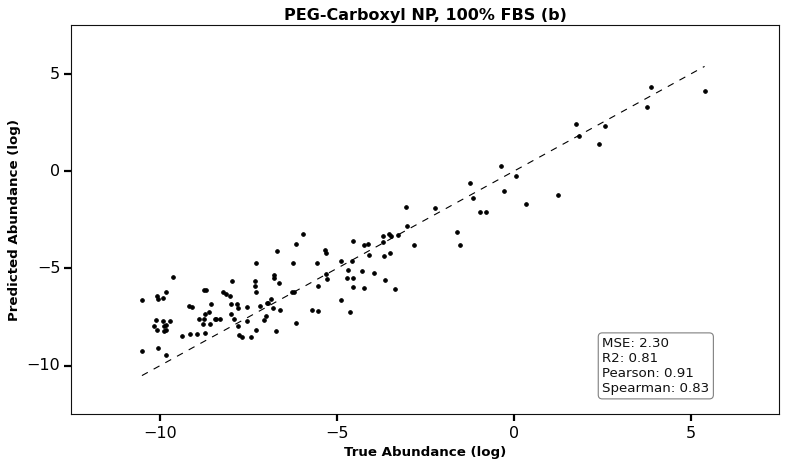

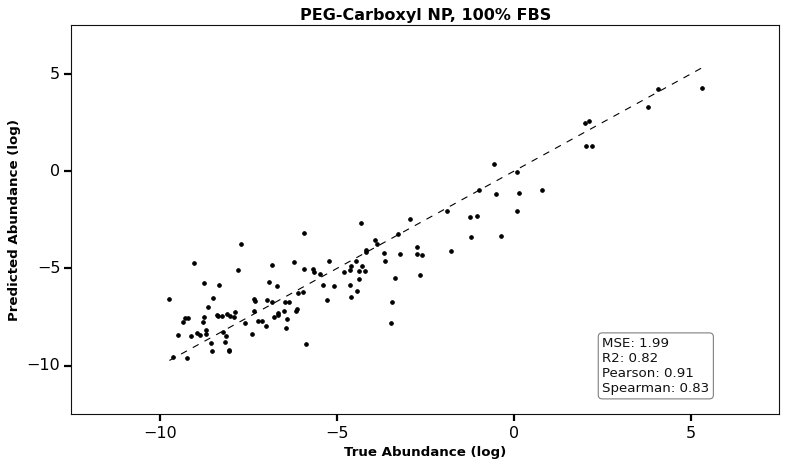

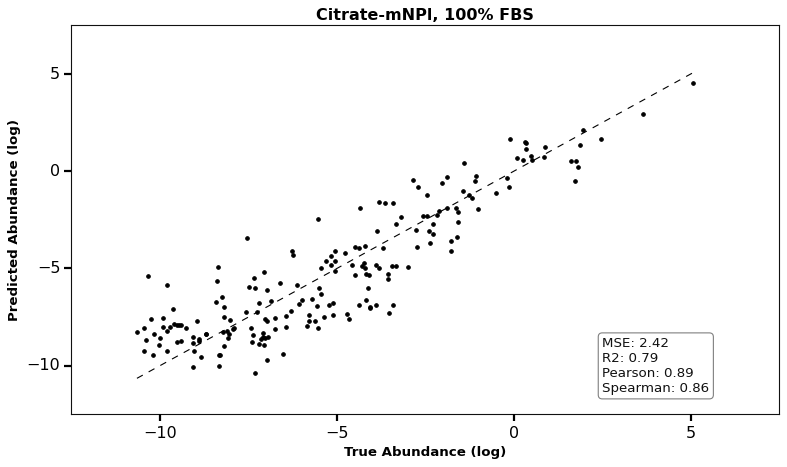

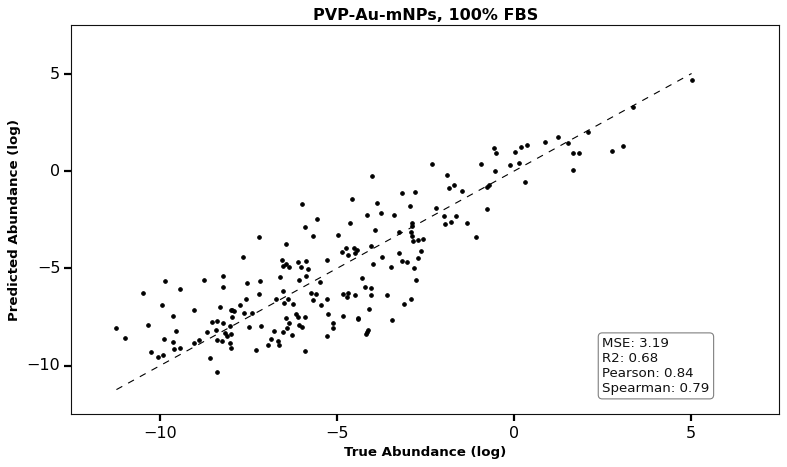

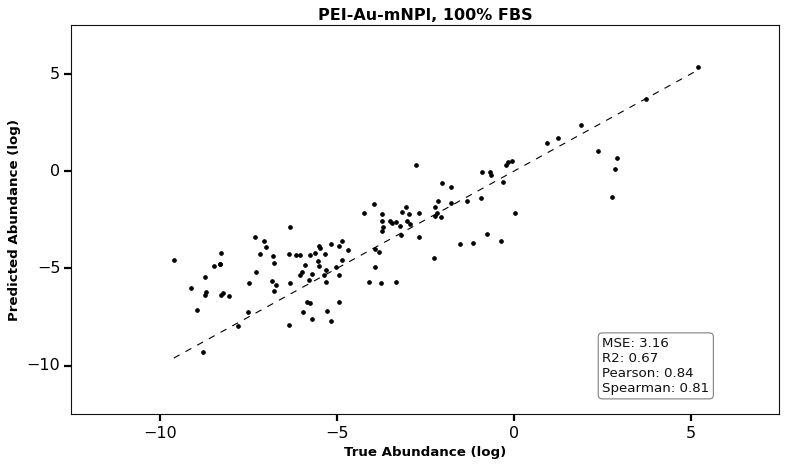

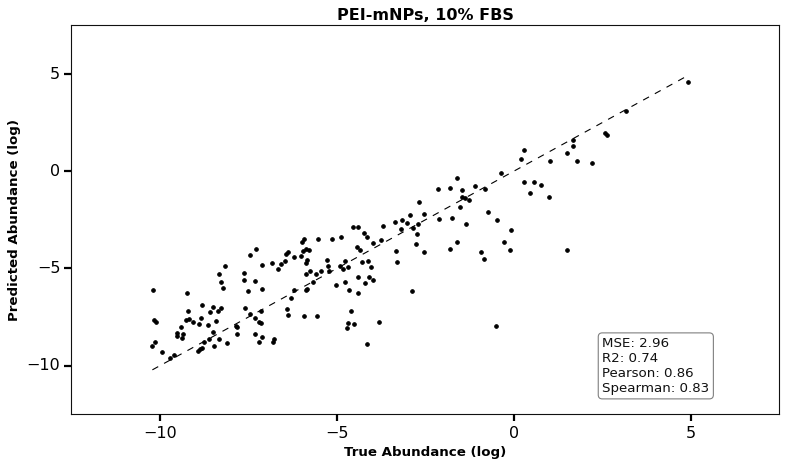

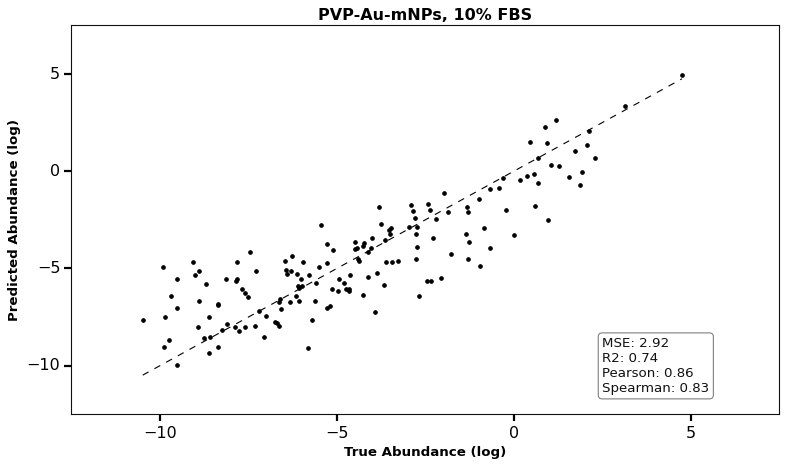

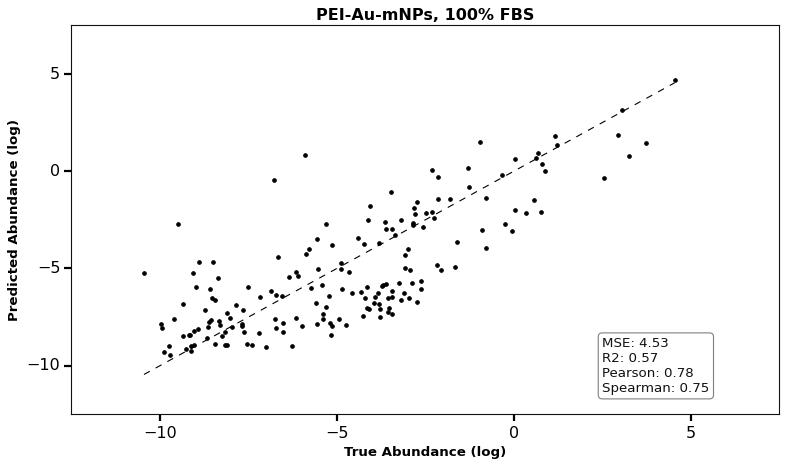

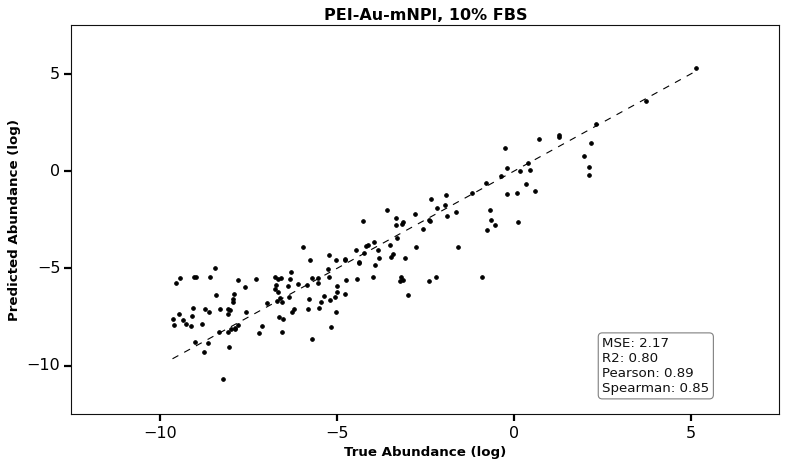

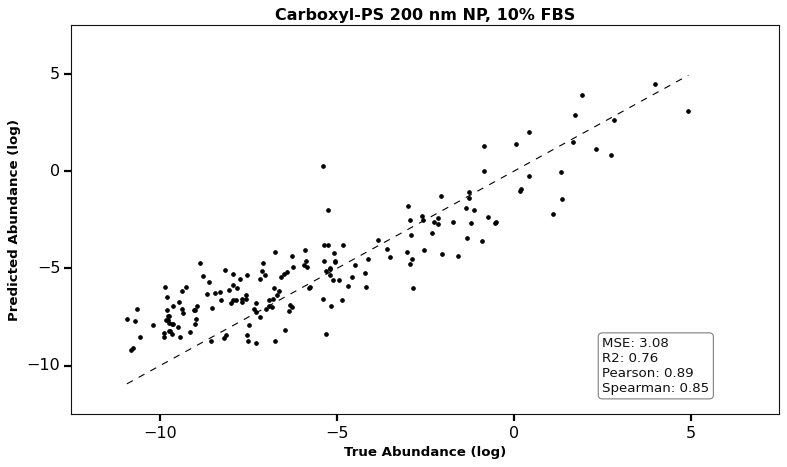

    Pearson  Spearman  R-squared  Mean Squared Error  \
0  0.852742  0.773522   0.702142            3.128247   
0  0.844557  0.802513   0.709362            3.329087   
0  0.901261  0.880734   0.801508            2.649788   
0  0.906971  0.870473   0.813210            2.143631   
0  0.894179  0.849908   0.793419            2.292848   

                                ID  
0  Carboxyl-PS 200 nm NP, 100% FBS  
0                PEI-mNPl, 10% FBS  
0            Citrate-mNPl, 10% FBS  
0               PEI-mNPs, 100% FBS  
0            PVP-Au-mNPl, 100% FBS  


In [ ]:
npunid_to_full_name = {
    17: "Carboxyl-PS 200 nm NP, 10% FBS",
    18: "Carboxyl-PS 200 nm NP, 100% FBS",
    19: "Citrate-mNPs, 10% FBS",
    20: "Citrate-mNPl, 10% FBS",
    21: "PEI-mNPs, 10% FBS",
    22: "PEI-mNPl, 10% FBS",
    23: "PVP-Au-mNPl, 100% FBS",
    24: "PVP-Au-mNPs, 10% FBS",
    25: "PVP-Au-mNPs, 100% FBS",
    26: "Citrate-mNPl, 100% FBS",
    27: "PEI-mNPl, 100% FBS",
    28: "Citrate-mNPs, 100% FBS",
    29: "PEI-mNPs, 100% FBS",
    30: "PEI-Au-mNPl, 10% FBS",
    31: "PEG-Au-mNPl, 100% FBS",
    32: "PEI-Au-mNPl, 100% FBS",
    33: "PEI-Au-mNPs, 100% FBS",
    34: "PEG-Carboxyl NP, 100% FBS",
    35: "PEG-Carboxyl NP, 100% FBS (b)"
}

def predict_nanoparticles(train_set, test_set, name):
    # Initialize a RandomForestRegressor model with 100 estimators
    model = RandomForestRegressor(n_estimators=100)

    # Filter out rows with abundance values below zero for train_set
    Min_Abundance = train_set['Abundance'].drop_duplicates().nsmallest(2).iloc[-1]
    train_set = train_set[train_set['Abundance'] >= Min_Abundance].copy()

    # X is df and y is 'Abundance' column in df
    # 'Abundance' column in df represents a 1D array of target values (class labels)
    label_train = np.log2(train_set['Abundance'].to_numpy().astype(float))

    # Remove unnecessary columns
    columns_to_drop = [col for col in ['Abundance', 'NPUNID', 'Entry'] if col in train_set.columns]
    train_set.drop(columns=columns_to_drop, inplace=True)
    selected_features = train_set.columns.tolist()

    # Filter out rows with abundance values below zero for test_set
    Min_Abundance = test_set['Abundance'].drop_duplicates().nsmallest(2).iloc[-1]
    test_set = test_set[test_set['Abundance'] >= Min_Abundance].copy()

    label_pred = np.log2(test_set['Abundance'].to_numpy().astype(float))

    X_train = train_set[selected_features].copy()
    X_test = test_set[selected_features].copy()
    y_train = label_train
    y_test = label_pred

    # Train the classifier
    model.fit(X_train, y_train)

    # Evaluate on validation set
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    pearson, _ = pearsonr(y_test, y_pred)
    spearman, _ = spearmanr(y_test, y_pred)
    r_squared = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)

    # Create a scatter plot of true vs predicted values
    plt.style.use('classic')

    # Creating the figure and axes object with a specified size and background color
    fig, ax = plt.subplots(figsize=(10, 6), facecolor='white')

    # Set high resolution for clearer output
    plt.rcParams['figure.dpi'] = 300

    # Scatter plot of true vs. predicted values using adjusted color and marker size
    ax.scatter(y_test, y_pred, color='black', s=10)  # Using black for consistency and adjusting marker size

    # Identity line with adjusted color and line style
    ax.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='black')

    # Setting labels, title with customized options
    ax.set_xlabel('True Abundance (log)', fontweight='bold', color='black')
    ax.set_ylabel('Predicted Abundance (log)', fontweight='bold', color='black')
    ax.set_title(f"{name}", fontweight='bold', color='black')
    ax.set_xlim(left=-12.5, right=7.5)
    ax.set_ylim(bottom=-12.5, top=7.5)

    # Add a metrics box to the plot with consistent styling
    box_text = f"MSE: {mse:.2f}\nR2: {r_squared:.2f}\nPearson: {pearson:.2f}\nSpearman: {spearman:.2f}"
    props = dict(boxstyle='round', facecolor='white', edgecolor='black', alpha=0.5)
    ax.text(0.75, 0.05, box_text, transform=ax.transAxes, fontsize=12, verticalalignment='bottom', bbox=props)

    # Adjusting the tick parameters for consistency
    ax.tick_params(axis='both', which='both', direction='out',
                   length=6, width=2, colors='black',
                   labelsize='large', labelcolor='black',
                   bottom=True, top=False, left=True, right=False)

    # Remove grid lines for a cleaner look
    ax.grid(False)

    # Ensure layout fits the plot and no clipping occurs
    plt.tight_layout()

    # Display the plot
    plt.show()

    # Close the plot explicitly to free up memory
    plt.close()

    results = pd.DataFrame({
        "Pearson": [pearson],
        "Spearman": [spearman],
        "R-squared": [r_squared],
        "Mean Squared Error": [mse],
        "ID": name  # This assumes 'name' is intended to be the identifier for the row
    })


    return results



# Manually selected file for 1) original (cleaned) df and 2) RFR RFECV results (to get best_features)
original_df = '/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Input_DataFrames/post_clean_up_dfs/RFR/df_Bov Swiss Intensity _original.xlsx'
feats_from_rfr_rfecv = '/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFR/df_RFECV_RFR_Bov SP Intensity training_data_original.xlsx'

df = pd.read_excel(original_df, header=0)
df_feats = pd.read_excel(feats_from_rfr_rfecv, header=0)

# Extract the list of column names from df_feats
# Assuming df_feats has a column called 'Features' or similar that contains the feature names
feats_columns = df_feats.columns.tolist()

# Filter df to only include the columns that match feats_columns, making a copy
df_filtered = df[feats_columns].copy()
# Create new evaluation df that will have the results of everything appended to it
full_eval = pd.DataFrame()

# Create a list of all unique NPUNID IDs in current df
np_ids = df['NPUNID'].unique().tolist()
print(np_ids)



for np_id in np_ids:
    # Filter df to only include rows with current NPUNID - test set
    current_np = df_filtered.loc[df['NPUNID'] == np_id].copy()
    # Filter df to only include rows without current NPUNID - train set
    temp_df = df_filtered.loc[df['NPUNID'] != np_id].copy()

    # Get full sample name
    full_name = npunid_to_full_name.get(np_id, f'ID: {np_id}')

    # Train RFR model to make predictions on current NPUNID entry
    eval = predict_nanoparticles(temp_df, current_np, full_name)

    # Append the test to the full evaluation df
    full_eval = pd.concat([full_eval, eval])

print(full_eval.head())

Pearson: 0.9002003137473914
Spearman: 0.8601429238910325
R-squared: 0.8076928863512441
Mean Squared Error: 2.3703392782441255
Predictions saved to /content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFR/protein_abundance_predictions_comparison.xlsx


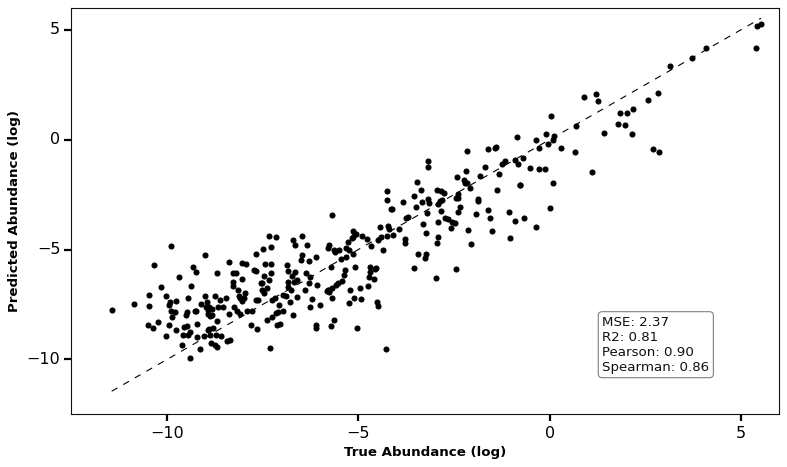

Model evaluation for Bovine SP Intensity is complete!


In [ ]:
def predict_file(train_file, test_file, name):
    # Initialize a RandomForestRegressor model with 100 estimators
    model = RandomForestRegressor(n_estimators=100, random_state=42)

    # Read the input training DataFrame
    df_train = pd.read_excel(train_file, header=0)

    # Log-transform the 'Abundance' target variable for training
    y_train = np.log2(df_train['Abundance'].to_numpy().astype(float))

    # Drop unnecessary columns in both training and test sets
    columns_to_drop = ['Abundance', 'NPUNID', 'Entry']
    df_train.drop(columns=[col for col in columns_to_drop if col in df_train.columns], inplace=True)

    # Read the input test DataFrame
    df_test = pd.read_excel(test_file, header=0)

    # Log-transform the 'Abundance' target variable for testing
    y_test = np.log2(df_test['Abundance'].to_numpy().astype(float))

    # Store relevant protein identifiers
    proteins = df_test['Entry'] if 'Entry' in df_test.columns else None

    selected_features = df_train.columns

    X_train = df_train[selected_features].copy()
    X_test = df_test[selected_features].copy()

    # Fit the model and make predictions
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate evaluation metrics
    pearson, _ = pearsonr(y_test, y_pred)
    spearman, _ = spearmanr(y_test, y_pred)
    r_squared = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)

    print("Pearson:", pearson)
    print("Spearman:", spearman)
    print("R-squared:", r_squared)
    print("Mean Squared Error:", mse)

    # Save true and predicted abundance values to an Excel file
    results = pd.DataFrame({
        'Protein': proteins,  # Protein identifiers from the 'Entry' column
        'True Abundance (log)': y_test,
        'Predicted Abundance (log)': y_pred
    })

    #output_path = f"{name}_predictions.xlsx"
    output_path = '/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFR/protein_abundance_predictions_comparison.xlsx'
    results.to_excel(output_path, index=False)
    print(f"Predictions saved to {output_path}")

    # Create the scatter plot (as in your existing code)
    plt.style.use('classic')
    fig, ax = plt.subplots(figsize=(10, 6), facecolor='white')
    plt.rcParams['figure.dpi'] = 300
    ax.scatter(y_test, y_pred, color='black', s=20)
    ax.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='black')
    ax.set_xlabel('True Abundance (log)', fontweight='bold', color='black')
    ax.set_ylabel('Predicted Abundance (log)', fontweight='bold', color='black')
    ax.tick_params(axis='both', which='both', direction='out', length=6, width=2, colors='black',
                   labelsize='large', labelcolor='black', bottom=True, top=False, left=True, right=False)
    ax.set_xlim(left=-12.5, right=6)
    ax.set_ylim(bottom=-12.5, top=6)
    box_text = f"MSE: {mse:.2f}\nR2: {r_squared:.2f}\nPearson: {pearson:.2f}\nSpearman: {spearman:.2f}"
    props = dict(boxstyle='round', facecolor='white', alpha=0.5, edgecolor='black')
    ax.text(0.75, 0.10, box_text, transform=ax.transAxes, fontsize=12, verticalalignment='bottom', bbox=props)
    ax.grid(False)
    plt.tight_layout()
    plt.show()
    plt.close()

    print(f"Model evaluation for {name} is complete!")

# Call the function for a single file without threading
predict_file('/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Output_DataFrames/RFR/df_RFECV_RFR_Bov SP Intensity training_data_original.xlsx', '/content/drive/MyDrive/ProteinCoronaPredict_PayneLab/Input_DataFrames/post_clean_up_dfs/RFR/test_data_Bov SP Intensity_original.xlsx', 'Bovine SP Intensity')

